In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

from tqdm import tqdm
import torch
import time
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# import gym
# import recogym

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
import optuna
# from memory_profiler import profile

from plots_and_stats import compute_statistics_and_plots, plot_ope_study_diagnostics

from estimators import (
    DirectMethod as DM
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    CustomCFDataset,
    calc_reward,
    get_weights_info
)

from models import (    
    LinearCFModel,
    NeighborhoodModel,
    BPRModel, 
    RegressionModel
)

from training_utils import (
    train,
    validation_loop, 
    cv_score_model
 )


from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial
)


random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda
Using device: cuda
Using device: cuda


## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

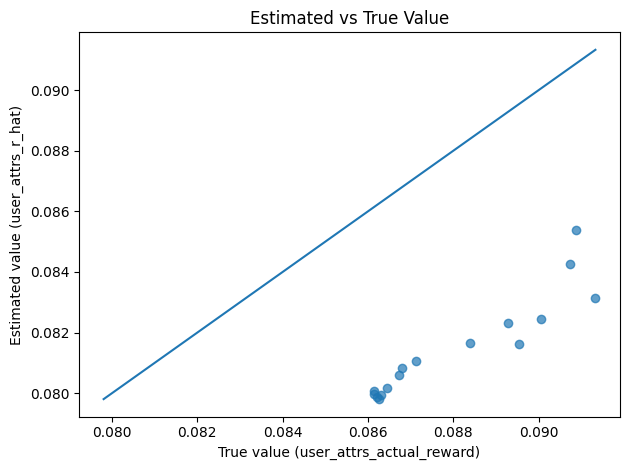

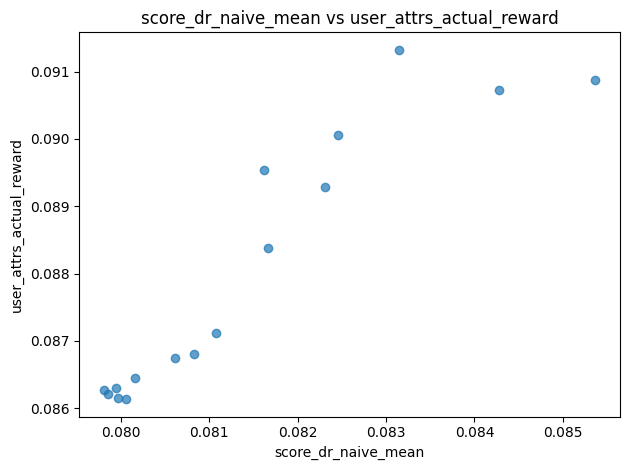

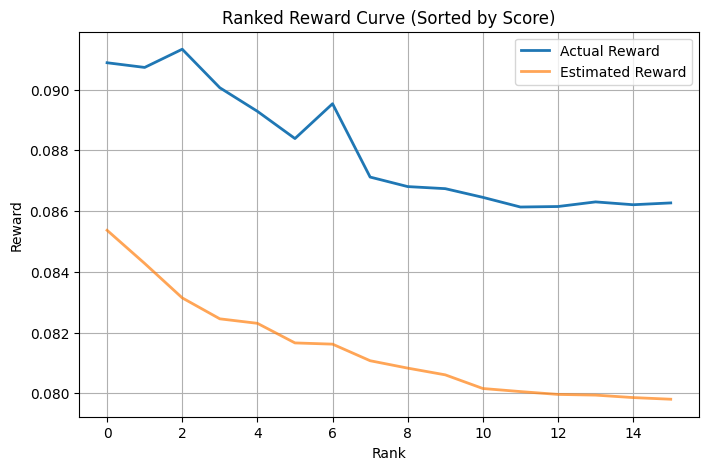

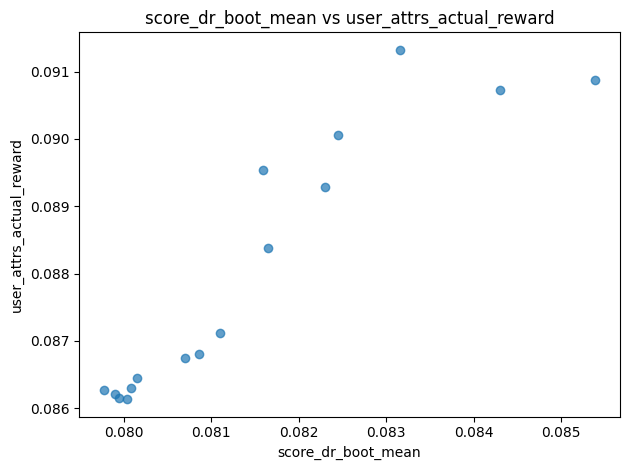

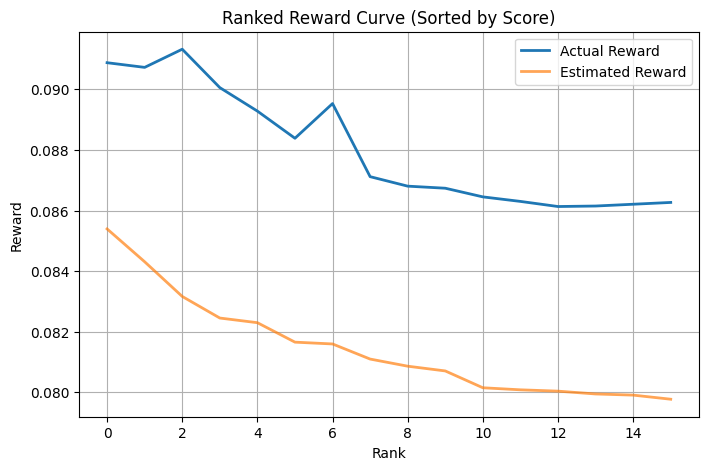

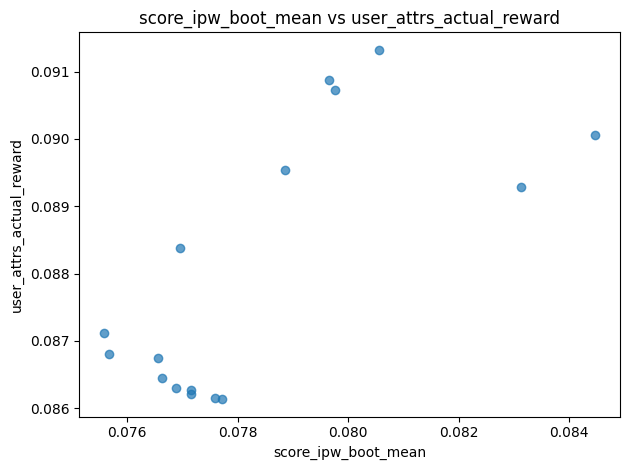

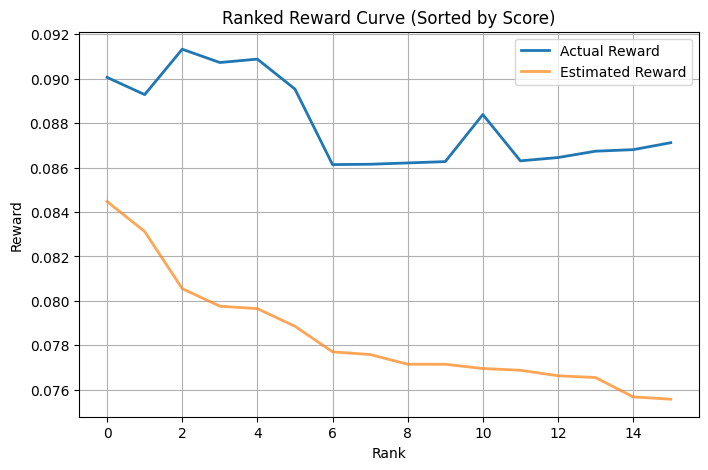

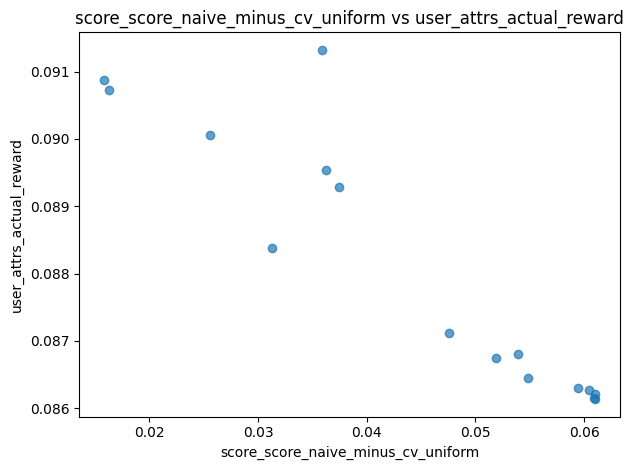

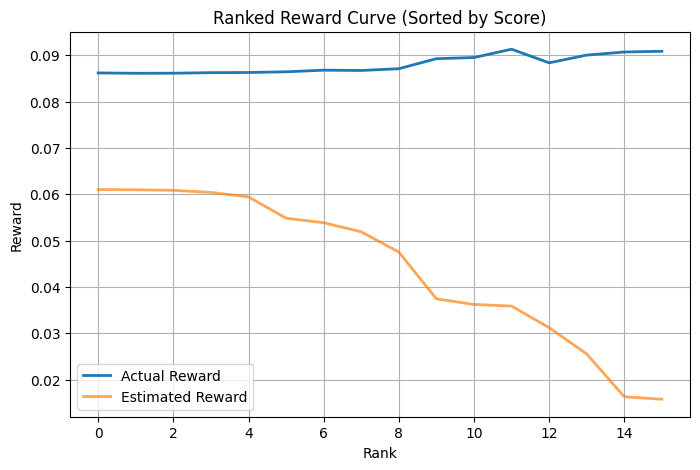

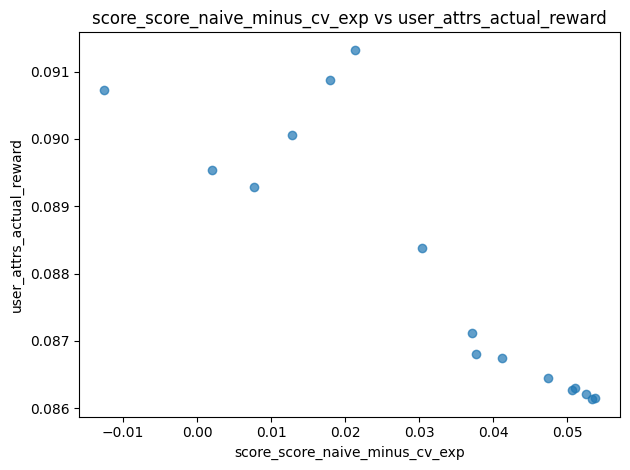

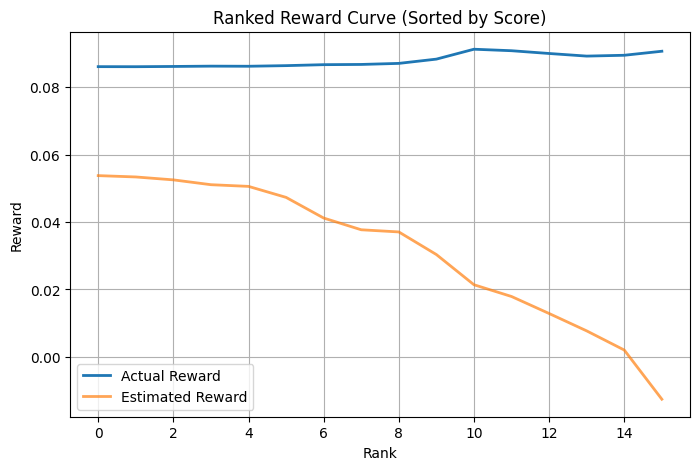

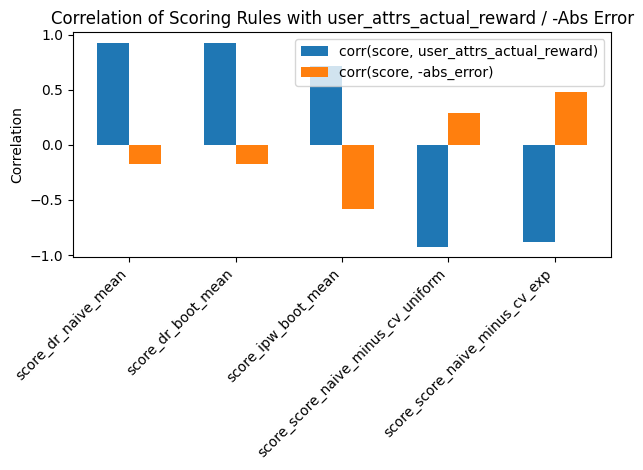

In [2]:
df = pd.read_csv("trial_dfs/study_df_27_12345.csv")

full_df = plot_ope_study_diagnostics(
    df,
    true_col="user_attrs_actual_reward",   # <-- NOW THIS IS THE TRUTH
    est_col="user_attrs_r_hat"
)

In [16]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07066414727263938
Optimal greedy CTR: 0.09999926940951757
Second Best greedy CTR: 0.0980913477695915
Optimal Stochastic CTR: 0.09995326955796031
second Best Stochastic CTR: 0.08595012935428775
Our Initial CTR: 0.08610747363354625


In [17]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 27
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [15000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.096,  # Learning rate
    "num_epochs": 5,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.85  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [18]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Value of num_rounds_list: [15000]
Simulation time for 10000 samples: 0.03451085090637207 seconds
[Regression] Baseline regression model fit time: 0.08s
Num samples is 10000
{'gini': np.float64(0.47349252772439), 'ess': np.float64(3760.650942750882), 'max_wi': np.float64(43.393713654295446), 'min_wi': np.float64(0.010335728051020824)}
Eval time: 0.5515036582946777 seconds


[I 2025-12-09 10:35:57,929] A new study created in memory with name: no-name-fdfac599-cae9-4039-919b-ba0debce1dc6


Evaluation total results time: 0.94 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.05915212631225586 seconds


  0%|          | 0/27 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.07933615]
Validation weights_info: {'gini': np.float64(0.9925120223730091), 'ess': np.float64(8.396901690045993), 'max_wi': np.float64(3917.586649893535), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   4%|▎         | 1/27 [00:03<01:34,  3.64s/it]

[I 2025-12-09 10:36:01,574] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1


Best trial: 1. Best value: 0.0842405:   7%|▋         | 2/27 [00:06<01:13,  2.96s/it]

actual reward: [0.09088038]
Validation weights_info: {'gini': np.float64(0.9492314249569285), 'ess': np.float64(296.9824013754553), 'max_wi': np.float64(161.78039841169618), 'min_wi': np.float64(2.7688807564446634e-06)}
[I 2025-12-09 10:36:04,049] Trial 1 finished with value: 0.08424054131444285 and parameters: {'lr': 0.003290588987609452, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9594483835214558}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 2


Best trial: 1. Best value: 0.0842405:  11%|█         | 3/27 [00:07<00:52,  2.18s/it]

actual reward: [0.08630128]
Validation weights_info: {'gini': np.float64(0.3040494841403925), 'ess': np.float64(7138.611306474146), 'max_wi': np.float64(3.5724360697405517), 'min_wi': np.float64(0.2350475092256557)}
[I 2025-12-09 10:36:05,310] Trial 2 finished with value: 0.07645629786992979 and parameters: {'lr': 0.0025167610939342447, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9250664467339295}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 3


Best trial: 1. Best value: 0.0842405:  15%|█▍        | 4/27 [00:09<00:51,  2.24s/it]

actual reward: [0.09125446]
Validation weights_info: {'gini': np.float64(0.9733863794796171), 'ess': np.float64(48.26402858277817), 'max_wi': np.float64(898.1459795527819), 'min_wi': np.float64(4.081873495314522e-07)}
[I 2025-12-09 10:36:07,635] Trial 3 finished with value: -inf and parameters: {'lr': 0.006514647204475884, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9131760116528433}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 4
actual reward: [0.08329879]
Validation weights_info: {'gini': np.float64(0.9954143209717434), 'ess': np.float64(9.11682669377576), 'max_wi': np.float64(2746.8138337965693), 'min_wi': np.float64(3.0980906007826546e-14)}


Best trial: 1. Best value: 0.0842405:  19%|█▊        | 5/27 [00:10<00:40,  1.86s/it]

[I 2025-12-09 10:36:08,820] Trial 4 finished with value: -inf and parameters: {'lr': 0.0543042068721328, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9405074618536915}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 5
actual reward: [0.09012321]
Validation weights_info: {'gini': np.float64(0.9925228570504435), 'ess': np.float64(13.867604600127436), 'max_wi': np.float64(1502.131874190897), 'min_wi': np.float64(3.700209189958869e-19)}


Best trial: 1. Best value: 0.0842405:  22%|██▏       | 6/27 [00:13<00:47,  2.25s/it]

[I 2025-12-09 10:36:11,823] Trial 5 finished with value: -inf and parameters: {'lr': 0.05370020385805652, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8579774578594297}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 6
actual reward: [0.08931319]
Validation weights_info: {'gini': np.float64(0.9792446165443721), 'ess': np.float64(66.62783446372886), 'max_wi': np.float64(596.644284279302), 'min_wi': np.float64(1.1175548851281083e-07)}


Best trial: 1. Best value: 0.0842405:  26%|██▌       | 7/27 [00:16<00:48,  2.44s/it]

[I 2025-12-09 10:36:14,664] Trial 6 finished with value: -inf and parameters: {'lr': 0.007576805718156063, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8396023248763681}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 7
actual reward: [0.09132558]
Validation weights_info: {'gini': np.float64(0.9119462246167981), 'ess': np.float64(688.8424234003726), 'max_wi': np.float64(41.96118271753015), 'min_wi': np.float64(5.619426307616054e-06)}


Best trial: 1. Best value: 0.0842405:  30%|██▉       | 8/27 [00:18<00:42,  2.22s/it]

[I 2025-12-09 10:36:16,396] Trial 7 finished with value: 0.08172642781242523 and parameters: {'lr': 0.009926667839193475, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9904207148487133}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 8
actual reward: [0.09216368]
Validation weights_info: {'gini': np.float64(0.9884795164552521), 'ess': np.float64(34.399360017948474), 'max_wi': np.float64(660.8140870658644), 'min_wi': np.float64(4.3335871323247116e-14)}


Best trial: 1. Best value: 0.0842405:  33%|███▎      | 9/27 [00:24<00:58,  3.28s/it]

[I 2025-12-09 10:36:22,007] Trial 8 finished with value: -inf and parameters: {'lr': 0.011084185117250464, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9447289205464754}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 9
actual reward: [0.08680515]
Validation weights_info: {'gini': np.float64(0.6635550054681194), 'ess': np.float64(2606.131682686682), 'max_wi': np.float64(14.551778830465619), 'min_wi': np.float64(0.012291285088025324)}


Best trial: 1. Best value: 0.0842405:  37%|███▋      | 10/27 [00:30<01:10,  4.16s/it]

[I 2025-12-09 10:36:28,132] Trial 9 finished with value: 0.07849646759654473 and parameters: {'lr': 0.000651721186876096, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8138287022928727}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 10
actual reward: [0.08614904]
Validation weights_info: {'gini': np.float64(0.07735246079170441), 'ess': np.float64(9782.981541344325), 'max_wi': np.float64(1.4486218220798652), 'min_wi': np.float64(0.722865200395339)}


Best trial: 1. Best value: 0.0842405:  41%|████      | 11/27 [00:32<00:56,  3.56s/it]

[I 2025-12-09 10:36:30,345] Trial 10 finished with value: 0.07598168147184234 and parameters: {'lr': 0.00010826034100092733, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9706224145433217}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 11
actual reward: [0.08645103]
Validation weights_info: {'gini': np.float64(0.4448040313623129), 'ess': np.float64(5069.294647644226), 'max_wi': np.float64(6.389764010633853), 'min_wi': np.float64(0.10218840502829195)}


Best trial: 1. Best value: 0.0842405:  44%|████▍     | 12/27 [00:33<00:44,  2.95s/it]

[I 2025-12-09 10:36:31,889] Trial 11 finished with value: 0.0771250928279636 and parameters: {'lr': 0.0015966730645762793, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9961782422724146}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 12
actual reward: [0.08698146]
Validation weights_info: {'gini': np.float64(0.9968316289496743), 'ess': np.float64(9.663830217105346), 'max_wi': np.float64(3084.9967539061017), 'min_wi': np.float64(3.5479049322991115e-10)}


Best trial: 1. Best value: 0.0842405:  48%|████▊     | 13/27 [00:35<00:37,  2.67s/it]

[I 2025-12-09 10:36:33,925] Trial 12 finished with value: -inf and parameters: {'lr': 0.019234171438061404, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9942769810529707}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 13
actual reward: [0.08620804]
Validation weights_info: {'gini': np.float64(0.14088350696187338), 'ess': np.float64(9290.253554327486), 'max_wi': np.float64(1.9235712456208334), 'min_wi': np.float64(0.558730906242756)}


Best trial: 1. Best value: 0.0842405:  52%|█████▏    | 14/27 [00:37<00:29,  2.29s/it]

[I 2025-12-09 10:36:35,337] Trial 13 finished with value: 0.07596947376913599 and parameters: {'lr': 0.0007065392854155976, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9640556891841423}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 14
actual reward: [0.08926812]
Validation weights_info: {'gini': np.float64(0.9969361858065209), 'ess': np.float64(13.149431474763093), 'max_wi': np.float64(2182.4139002712413), 'min_wi': np.float64(2.7149266358005027e-11)}


Best trial: 1. Best value: 0.0842405:  56%|█████▌    | 15/27 [00:39<00:26,  2.24s/it]

[I 2025-12-09 10:36:37,470] Trial 14 finished with value: -inf and parameters: {'lr': 0.019201816134488937, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8890702625014691}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 15
actual reward: [0.08673692]
Validation weights_info: {'gini': np.float64(0.5991770525924176), 'ess': np.float64(3176.5260858782663), 'max_wi': np.float64(11.09655660303358), 'min_wi': np.float64(0.034361069837654024)}


Best trial: 1. Best value: 0.0842405:  59%|█████▉    | 16/27 [00:41<00:23,  2.16s/it]

[I 2025-12-09 10:36:39,435] Trial 15 finished with value: 0.07808256401265945 and parameters: {'lr': 0.0013026142562537818, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.968330933294478}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 16
actual reward: [0.09005823]
Validation weights_info: {'gini': np.float64(0.8893831230430475), 'ess': np.float64(874.6871933695671), 'max_wi': np.float64(35.44984968503086), 'min_wi': np.float64(9.231969836998522e-05)}


Best trial: 1. Best value: 0.0842405:  63%|██████▎   | 17/27 [00:43<00:20,  2.08s/it]

[I 2025-12-09 10:36:41,342] Trial 16 finished with value: 0.0810352617774365 and parameters: {'lr': 0.004548663236428053, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.880095843684653}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 17
actual reward: [0.0861327]
Validation weights_info: {'gini': np.float64(0.04469366637836742), 'ess': np.float64(9927.052426480572), 'max_wi': np.float64(1.2546582452703279), 'min_wi': np.float64(0.8339274462632457)}


Best trial: 1. Best value: 0.0842405:  67%|██████▋   | 18/27 [00:44<00:17,  1.91s/it]

[I 2025-12-09 10:36:42,834] Trial 17 finished with value: 0.07604813188557955 and parameters: {'lr': 0.00022788518126626257, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9825676290147571}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 18
actual reward: [0.08854584]
Validation weights_info: {'gini': np.float64(0.9936924495589867), 'ess': np.float64(23.11233192453063), 'max_wi': np.float64(661.1488176651114), 'min_wi': np.float64(2.4766579246990358e-11)}


Best trial: 1. Best value: 0.0842405:  70%|███████   | 19/27 [00:47<00:16,  2.05s/it]

[I 2025-12-09 10:36:45,204] Trial 18 finished with value: -inf and parameters: {'lr': 0.016544960307820936, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9470960985448571}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 19
actual reward: [0.08838609]
Validation weights_info: {'gini': np.float64(0.8289084872932863), 'ess': np.float64(1227.9915729339255), 'max_wi': np.float64(28.87164368941991), 'min_wi': np.float64(0.0012483294989070564)}


Best trial: 1. Best value: 0.0842405:  74%|███████▍  | 20/27 [00:49<00:14,  2.12s/it]

[I 2025-12-09 10:36:47,496] Trial 19 finished with value: 0.0799413696803877 and parameters: {'lr': 0.003173925041786598, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9101341541412381}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 20
actual reward: [0.08535107]
Validation weights_info: {'gini': np.float64(0.9964252709230128), 'ess': np.float64(9.890670104506537), 'max_wi': np.float64(1623.5651554961833), 'min_wi': np.float64(1.608500525094527e-09)}


Best trial: 1. Best value: 0.0842405:  78%|███████▊  | 21/27 [00:51<00:11,  1.94s/it]

[I 2025-12-09 10:36:49,033] Trial 20 finished with value: -inf and parameters: {'lr': 0.03239559056652599, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9554174884509428}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 21
actual reward: [0.08928279]
Validation weights_info: {'gini': np.float64(0.8669161559991804), 'ess': np.float64(1050.3728337456419), 'max_wi': np.float64(30.01976222896318), 'min_wi': np.float64(0.0002541298515840881)}


Best trial: 1. Best value: 0.0842405:  81%|████████▏ | 22/27 [00:53<00:09,  1.93s/it]

[I 2025-12-09 10:36:50,932] Trial 21 finished with value: 0.08078076484610672 and parameters: {'lr': 0.004041774430418458, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8756686245679747}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 22
actual reward: [0.09072637]
Validation weights_info: {'gini': np.float64(0.914869009865172), 'ess': np.float64(616.3777425032266), 'max_wi': np.float64(67.8994289233445), 'min_wi': np.float64(1.3880520589926313e-05)}


Best trial: 1. Best value: 0.0842405:  85%|████████▌ | 23/27 [00:55<00:07,  1.99s/it]

[I 2025-12-09 10:36:53,074] Trial 22 finished with value: 0.08296222752214667 and parameters: {'lr': 0.004811216144126055, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8738566991313926}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 23
actual reward: [0.0871185]
Validation weights_info: {'gini': np.float64(0.7464357869094084), 'ess': np.float64(1833.0584774633903), 'max_wi': np.float64(21.11041035516288), 'min_wi': np.float64(0.005433907686523269)}


Best trial: 1. Best value: 0.0842405:  89%|████████▉ | 24/27 [00:57<00:06,  2.04s/it]

[I 2025-12-09 10:36:55,212] Trial 23 finished with value: 0.07905485244986246 and parameters: {'lr': 0.0017189875595351235, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9287731940654576}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 24
actual reward: [0.08782262]
Validation weights_info: {'gini': np.float64(0.9933989465894468), 'ess': np.float64(21.25467564345776), 'max_wi': np.float64(719.705981604886), 'min_wi': np.float64(1.2874454857548534e-09)}


Best trial: 1. Best value: 0.0842405:  93%|█████████▎| 25/27 [00:59<00:04,  2.18s/it]

[I 2025-12-09 10:36:57,709] Trial 24 finished with value: -inf and parameters: {'lr': 0.008812054435019197, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9806470791143268}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 25
actual reward: [0.08626759]
Validation weights_info: {'gini': np.float64(0.2333728517438908), 'ess': np.float64(8184.460690842299), 'max_wi': np.float64(2.7378750898691364), 'min_wi': np.float64(0.3329656583897391)}


Best trial: 1. Best value: 0.0842405:  96%|█████████▋| 26/27 [01:01<00:02,  2.14s/it]

[I 2025-12-09 10:36:59,752] Trial 25 finished with value: 0.07611945449876288 and parameters: {'lr': 0.0006634824472795691, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8183596181916885}. Best is trial 1 with value: 0.08424054131444285.

[Regression] Optuna Trial 26
actual reward: [0.08953129]
Validation weights_info: {'gini': np.float64(0.8751664459409988), 'ess': np.float64(907.1561489086055), 'max_wi': np.float64(34.36239334504643), 'min_wi': np.float64(0.00015696974665346035)}


Best trial: 1. Best value: 0.0842405: 100%|██████████| 27/27 [01:03<00:00,  2.37s/it]


[I 2025-12-09 10:37:01,815] Trial 26 finished with value: 0.08009431499324769 and parameters: {'lr': 0.0046368626479512415, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9020646678649997}. Best is trial 1 with value: 0.08424054131444285.
Num samples is 10000
{'gini': np.float64(0.9808994399142392), 'ess': np.float64(66.29247550411137), 'max_wi': np.float64(634.8064268686574), 'min_wi': np.float64(2.3756903703295234e-07)}
Eval time: 0.45250415802001953 seconds
Evaluation total results time: 0.81 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08610747,0.08630000,0.08609254,0.08609254,0.08613344,0.08613344,0.75692870,0.00000000,0.87627132,0.00000000
15000,0.09049321,0.08176256,0.08882700,0.08882700,0.08475852,0.08425133,0.89262604,0.34376305,0.94626170,0.20687466


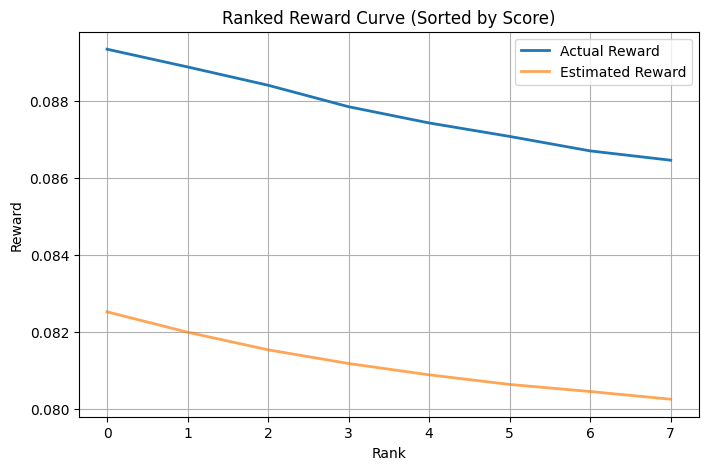

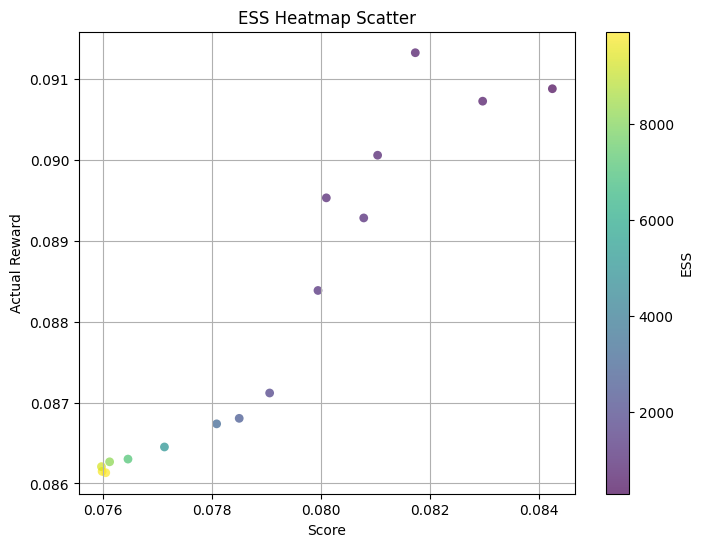

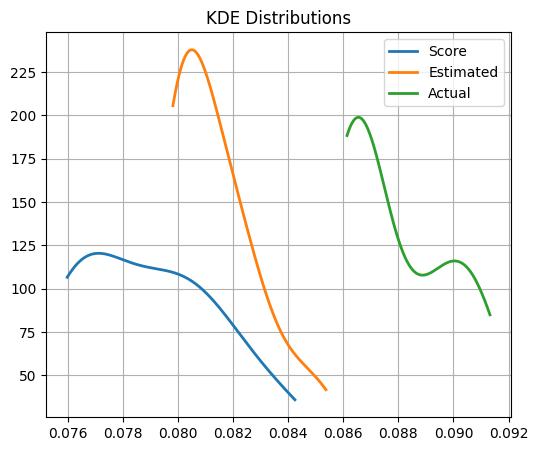

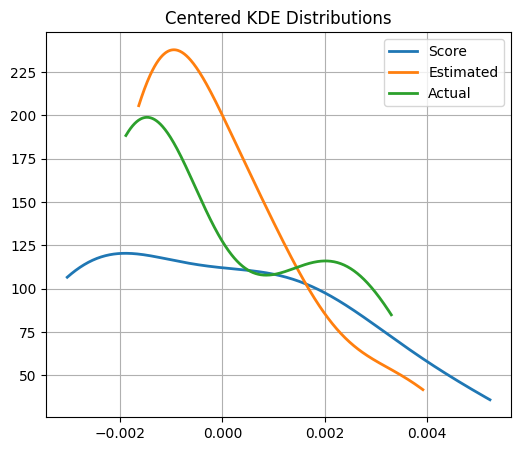

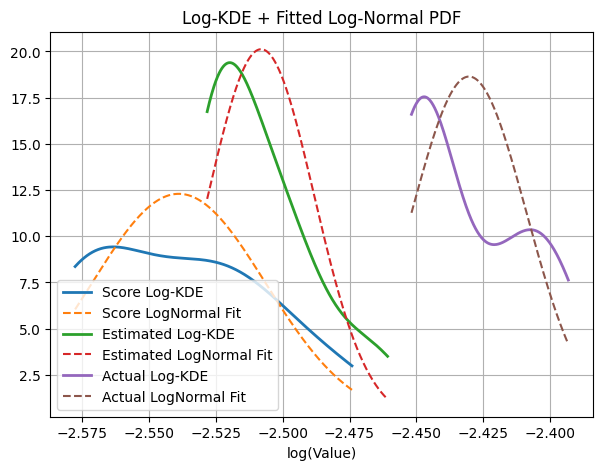

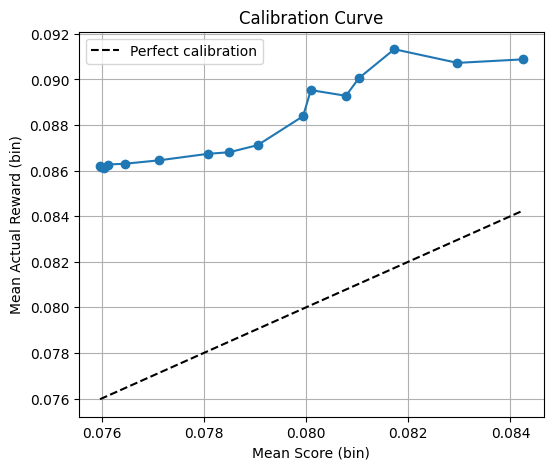

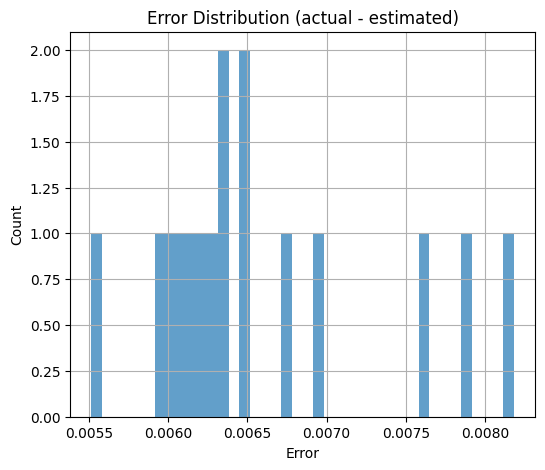

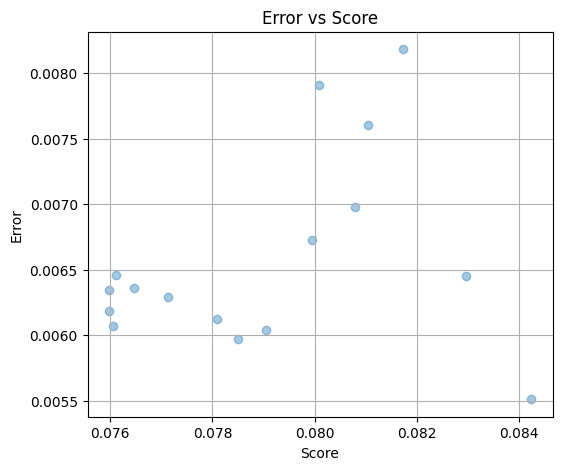

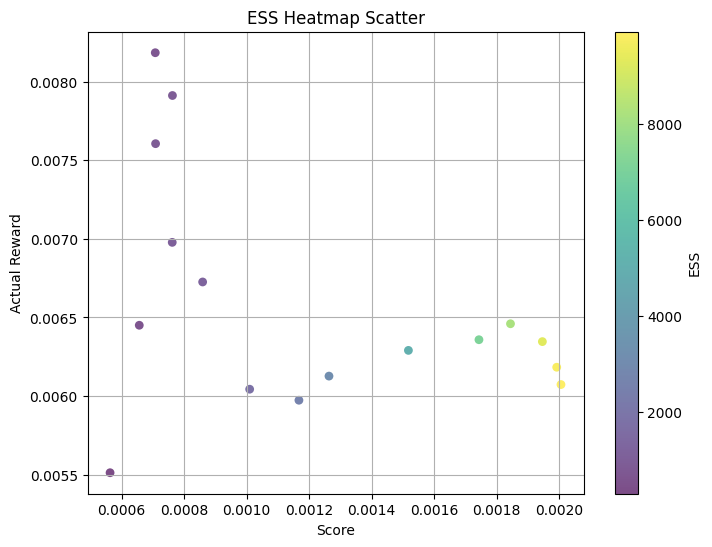

Correlation Metrics: {'pearson_score_actual': np.float64(0.9463743995824488), 'spearman_score_actual': np.float64(0.976470588235294), 'spearman_est_actual': np.float64(0.9323529411764706)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9995214890422878), 'ndcg_est_actual': np.float64(0.9994636453957618)}
Error Metrics: {'mean_error': np.float64(0.006576534775349768), 'mae': np.float64(0.006576534775349768), 'rmse': np.float64(0.006615394581210502), 'std_error': np.float64(0.000715985903300092), 'max_error': np.float64(0.00818318995164144), 'min_error': np.float64(0.0055129989852360645)}


In [19]:
study_df.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{12345}.csv")

compute_statistics_and_plots(study_df)

### Policy with delta function

In [20]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=10000)

Random Item CTR: 0.07083863592474163
Optimal greedy CTR: 0.09999916436977967
Second Best greedy CTR: 0.08797326118616329
Optimal Stochastic CTR: 0.0999493542444427
second Best Stochastic CTR: 0.0854530317781557
Our Initial CTR: 0.08557719469284641


In [21]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df5.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{10000}.csv")

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.06456303596496582 seconds
[Regression] Baseline regression model fit time: 0.03s
Num samples is 10000
{'gini': np.float64(0.4661849474839435), 'ess': np.float64(4152.265055141436), 'max_wi': np.float64(46.62999267261383), 'min_wi': np.float64(0.007936699153905062)}
Eval time: 0.6701085567474365 seconds


[I 2025-12-09 10:37:08,124] A new study created in memory with name: no-name-6d160c8c-6947-4c93-ab0a-bd075c34b4ee


Evaluation total results time: 1.06 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.06654500961303711 seconds


  0%|          | 0/27 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.07986131]
Validation weights_info: {'gini': np.float64(0.9668306933592984), 'ess': np.float64(331.42970932725876), 'max_wi': np.float64(117.65517476479275), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: 0.0845045:   4%|▎         | 1/27 [00:03<01:39,  3.82s/it]

[I 2025-12-09 10:37:11,942] Trial 0 finished with value: 0.08450453639152591 and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 1
actual reward: [0.08741099]
Validation weights_info: {'gini': np.float64(0.8842326813254937), 'ess': np.float64(765.8474742945368), 'max_wi': np.float64(135.58023346941684), 'min_wi': np.float64(4.610803032497999e-05)}


Best trial: 0. Best value: 0.0845045:   7%|▋         | 2/27 [00:05<01:03,  2.53s/it]

[I 2025-12-09 10:37:13,563] Trial 1 finished with value: 0.0834480173537405 and parameters: {'lr': 0.010107815527481278, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.893569882256862}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 2
actual reward: [0.08258393]
Validation weights_info: {'gini': np.float64(0.8130292623600799), 'ess': np.float64(1493.5585531373006), 'max_wi': np.float64(19.796580748553644), 'min_wi': np.float64(0.0020757795200064856)}


Best trial: 0. Best value: 0.0845045:  11%|█         | 3/27 [00:07<00:50,  2.09s/it]

[I 2025-12-09 10:37:15,135] Trial 2 finished with value: 0.07804651468388929 and parameters: {'lr': 0.003969199764537329, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8580654991151575}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 3
actual reward: [0.08655931]
Validation weights_info: {'gini': np.float64(0.9752690244096142), 'ess': np.float64(78.76994800911022), 'max_wi': np.float64(353.639887290885), 'min_wi': np.float64(2.387820588064369e-06)}


Best trial: 0. Best value: 0.0845045:  15%|█▍        | 4/27 [00:08<00:46,  2.03s/it]

[I 2025-12-09 10:37:17,083] Trial 3 finished with value: -inf and parameters: {'lr': 0.006779680660124263, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8641535153695028}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 4
actual reward: [0.08537855]
Validation weights_info: {'gini': np.float64(0.13751702219279927), 'ess': np.float64(9289.934969992179), 'max_wi': np.float64(1.9476259047819555), 'min_wi': np.float64(0.5636310017135956)}


Best trial: 0. Best value: 0.0845045:  19%|█▊        | 5/27 [00:11<00:49,  2.26s/it]

[I 2025-12-09 10:37:19,733] Trial 4 finished with value: 0.07536452602617043 and parameters: {'lr': 0.00012385107709229383, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9373198866692684}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 5
actual reward: [0.08118708]
Validation weights_info: {'gini': np.float64(0.9981397135674868), 'ess': np.float64(3.2026556436579607), 'max_wi': np.float64(8291.98169665542), 'min_wi': np.float64(4.6738302780076875e-30)}


Best trial: 0. Best value: 0.0845045:  22%|██▏       | 6/27 [00:13<00:44,  2.13s/it]

[I 2025-12-09 10:37:21,608] Trial 5 finished with value: -inf and parameters: {'lr': 0.07460022886609831, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8381611165849463}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 6
actual reward: [0.08059826]
Validation weights_info: {'gini': np.float64(0.9957131159837544), 'ess': np.float64(15.085239423053796), 'max_wi': np.float64(822.7130641244693), 'min_wi': np.float64(1.2008595078985964e-10)}


Best trial: 0. Best value: 0.0845045:  26%|██▌       | 7/27 [00:15<00:41,  2.08s/it]

[I 2025-12-09 10:37:23,602] Trial 6 finished with value: -inf and parameters: {'lr': 0.012381731730363294, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8998126809507644}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 7
actual reward: [0.08534849]
Validation weights_info: {'gini': np.float64(0.9978469631477198), 'ess': np.float64(6.578499989427631), 'max_wi': np.float64(4024.0229331822666), 'min_wi': np.float64(5.975162910578655e-14)}


Best trial: 0. Best value: 0.0845045:  30%|██▉       | 8/27 [00:17<00:41,  2.18s/it]

[I 2025-12-09 10:37:25,999] Trial 7 finished with value: -inf and parameters: {'lr': 0.02751890971093885, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8883719796531679}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 8
actual reward: [0.08325959]
Validation weights_info: {'gini': np.float64(0.8213213416612674), 'ess': np.float64(1468.5013491810523), 'max_wi': np.float64(28.07945399627997), 'min_wi': np.float64(0.0012218488126834828)}


Best trial: 0. Best value: 0.0845045:  33%|███▎      | 9/27 [00:21<00:44,  2.50s/it]

[I 2025-12-09 10:37:29,182] Trial 8 finished with value: 0.07978357773899906 and parameters: {'lr': 0.0011122257692159862, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8374561606066597}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 9
actual reward: [0.08265892]
Validation weights_info: {'gini': np.float64(0.9957755212500795), 'ess': np.float64(13.137740228151522), 'max_wi': np.float64(953.1823996594286), 'min_wi': np.float64(1.2514998782829218e-11)}


Best trial: 0. Best value: 0.0845045:  37%|███▋      | 10/27 [00:23<00:43,  2.57s/it]

[I 2025-12-09 10:37:31,909] Trial 9 finished with value: -inf and parameters: {'lr': 0.013680781614631553, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9600132442028453}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 10
actual reward: [0.085011]
Validation weights_info: {'gini': np.float64(0.3061992324911358), 'ess': np.float64(6892.666626379425), 'max_wi': np.float64(3.7999083103346925), 'min_wi': np.float64(0.22306764061333348)}


Best trial: 0. Best value: 0.0845045:  41%|████      | 11/27 [00:25<00:36,  2.30s/it]

[I 2025-12-09 10:37:33,618] Trial 10 finished with value: 0.07559742610458395 and parameters: {'lr': 0.0006913825568759061, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8015203118117732}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 11
actual reward: [0.07447557]
Validation weights_info: {'gini': np.float64(0.9767307084670854), 'ess': np.float64(17.196665988183856), 'max_wi': np.float64(2626.605041040831), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: 0.0845045:  44%|████▍     | 12/27 [00:27<00:33,  2.26s/it]

[I 2025-12-09 10:37:35,791] Trial 11 finished with value: -inf and parameters: {'lr': 0.08400736125181381, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9383738167410025}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 12
actual reward: [0.08390238]
Validation weights_info: {'gini': np.float64(0.9989081708479541), 'ess': np.float64(5.8358258999379045), 'max_wi': np.float64(3530.65226003307), 'min_wi': np.float64(7.014395603739932e-12)}


Best trial: 0. Best value: 0.0845045:  48%|████▊     | 13/27 [00:29<00:29,  2.11s/it]

[I 2025-12-09 10:37:37,552] Trial 12 finished with value: -inf and parameters: {'lr': 0.03366945409514063, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9172101236734924}. Best is trial 0 with value: 0.08450453639152591.

[Regression] Optuna Trial 13
actual reward: [0.08689995]
Validation weights_info: {'gini': np.float64(0.9550230870618991), 'ess': np.float64(100.44266182752582), 'max_wi': np.float64(514.0656199448084), 'min_wi': np.float64(1.2059489812571861e-05)}


Best trial: 13. Best value: 0.0939588:  52%|█████▏    | 14/27 [00:33<00:34,  2.62s/it]

[I 2025-12-09 10:37:41,361] Trial 13 finished with value: 0.0939588333291123 and parameters: {'lr': 0.0015241760957035633, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9884742724429318}. Best is trial 13 with value: 0.0939588333291123.

[Regression] Optuna Trial 14
actual reward: [0.08669038]
Validation weights_info: {'gini': np.float64(0.9592627710519269), 'ess': np.float64(103.6605858731626), 'max_wi': np.float64(395.23005905717514), 'min_wi': np.float64(3.5392205391798454e-06)}


Best trial: 14. Best value: 0.0944739:  56%|█████▌    | 15/27 [00:37<00:37,  3.13s/it]

[I 2025-12-09 10:37:45,653] Trial 14 finished with value: 0.09447392816465335 and parameters: {'lr': 0.0013842783314754, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9989156821299991}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 15
actual reward: [0.08702516]
Validation weights_info: {'gini': np.float64(0.977437561036158), 'ess': np.float64(71.73117238602886), 'max_wi': np.float64(434.92550948590974), 'min_wi': np.float64(1.6401084922833013e-07)}


Best trial: 14. Best value: 0.0944739:  59%|█████▉    | 16/27 [00:43<00:44,  4.07s/it]

[I 2025-12-09 10:37:51,910] Trial 15 finished with value: -inf and parameters: {'lr': 0.0012528266220181536, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9951982011888268}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 16
actual reward: [0.08346732]
Validation weights_info: {'gini': np.float64(0.6846751716410024), 'ess': np.float64(2387.3088932269325), 'max_wi': np.float64(10.85291000303801), 'min_wi': np.float64(0.013702181038142889)}


Best trial: 14. Best value: 0.0944739:  63%|██████▎   | 17/27 [00:48<00:41,  4.15s/it]

[I 2025-12-09 10:37:56,230] Trial 16 finished with value: 0.07778466323841876 and parameters: {'lr': 0.0003207236286779689, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9978828391263168}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 17
actual reward: [0.0871071]
Validation weights_info: {'gini': np.float64(0.9610377745401874), 'ess': np.float64(105.56411648996738), 'max_wi': np.float64(444.67795783532046), 'min_wi': np.float64(4.292344693304498e-06)}


Best trial: 14. Best value: 0.0944739:  67%|██████▋   | 18/27 [00:52<00:39,  4.35s/it]

[I 2025-12-09 10:38:01,052] Trial 17 finished with value: 0.09433617290774131 and parameters: {'lr': 0.0013538374311068335, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9707897853886601}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 18
actual reward: [0.08305047]
Validation weights_info: {'gini': np.float64(0.7523612012770194), 'ess': np.float64(1872.7959911336534), 'max_wi': np.float64(13.863461677375268), 'min_wi': np.float64(0.004725256876574704)}


Best trial: 14. Best value: 0.0944739:  70%|███████   | 19/27 [00:57<00:35,  4.45s/it]

[I 2025-12-09 10:38:05,744] Trial 18 finished with value: 0.07852098550690756 and parameters: {'lr': 0.0003693421658509329, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9670488620858222}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 19
actual reward: [0.08721348]
Validation weights_info: {'gini': np.float64(0.986675051296116), 'ess': np.float64(46.10426238808921), 'max_wi': np.float64(658.52412236639), 'min_wi': np.float64(1.3820358866317201e-08)}


Best trial: 14. Best value: 0.0944739:  74%|███████▍  | 20/27 [01:02<00:31,  4.51s/it]

[I 2025-12-09 10:38:10,376] Trial 19 finished with value: -inf and parameters: {'lr': 0.002388357468069788, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.973999911248113}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 20
actual reward: [0.08616763]
Validation weights_info: {'gini': np.float64(0.9949574534236572), 'ess': np.float64(24.259796840216787), 'max_wi': np.float64(1044.042110949175), 'min_wi': np.float64(8.638800509874928e-10)}


Best trial: 14. Best value: 0.0944739:  78%|███████▊  | 21/27 [01:06<00:26,  4.42s/it]

[I 2025-12-09 10:38:14,608] Trial 20 finished with value: -inf and parameters: {'lr': 0.0036171403554648277, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9470551488284831}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 21
actual reward: [0.08726366]
Validation weights_info: {'gini': np.float64(0.9631123653446648), 'ess': np.float64(107.91564090721177), 'max_wi': np.float64(286.7067511807617), 'min_wi': np.float64(3.1861262145578736e-06)}


Best trial: 14. Best value: 0.0944739:  81%|████████▏ | 22/27 [01:10<00:20,  4.19s/it]

[I 2025-12-09 10:38:18,258] Trial 21 finished with value: 0.09413655128997779 and parameters: {'lr': 0.0018368710465766053, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9813130453208769}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 22
actual reward: [0.08301628]
Validation weights_info: {'gini': np.float64(0.8118673629752178), 'ess': np.float64(1522.839691821797), 'max_wi': np.float64(19.333996383345934), 'min_wi': np.float64(0.0017958418059075072)}


Best trial: 14. Best value: 0.0944739:  85%|████████▌ | 23/27 [01:14<00:16,  4.18s/it]

[I 2025-12-09 10:38:22,401] Trial 22 finished with value: 0.07964748879755143 and parameters: {'lr': 0.0005276530244826474, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9783357718730998}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 23
actual reward: [0.08667252]
Validation weights_info: {'gini': np.float64(0.9840049474317628), 'ess': np.float64(54.40687723710232), 'max_wi': np.float64(502.1997726624441), 'min_wi': np.float64(1.8648426154464147e-08)}


Best trial: 14. Best value: 0.0944739:  89%|████████▉ | 24/27 [01:19<00:13,  4.55s/it]

[I 2025-12-09 10:38:27,817] Trial 23 finished with value: -inf and parameters: {'lr': 0.002023265163279539, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9565189294872082}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 24
actual reward: [0.08528124]
Validation weights_info: {'gini': np.float64(0.19358113188367562), 'ess': np.float64(8624.027722540497), 'max_wi': np.float64(2.4425027702522137), 'min_wi': np.float64(0.3805563767808045)}


Best trial: 14. Best value: 0.0944739:  93%|█████████▎| 25/27 [01:22<00:08,  4.15s/it]

[I 2025-12-09 10:38:31,023] Trial 24 finished with value: 0.0754249211247958 and parameters: {'lr': 0.0001283156176090918, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9222722338411363}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 25
actual reward: [0.08921201]
Validation weights_info: {'gini': np.float64(0.9914492652441599), 'ess': np.float64(24.43529817105901), 'max_wi': np.float64(1157.690961804744), 'min_wi': np.float64(3.794617099125357e-11)}


Best trial: 14. Best value: 0.0944739:  96%|█████████▋| 26/27 [01:27<00:04,  4.32s/it]

[I 2025-12-09 10:38:35,766] Trial 25 finished with value: -inf and parameters: {'lr': 0.005010880160034354, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9802414946837646}. Best is trial 14 with value: 0.09447392816465335.

[Regression] Optuna Trial 26
actual reward: [0.0849277]
Validation weights_info: {'gini': np.float64(0.8711273337181206), 'ess': np.float64(903.8229243526762), 'max_wi': np.float64(75.8119694527306), 'min_wi': np.float64(0.0004424935529518198)}


Best trial: 14. Best value: 0.0944739: 100%|██████████| 27/27 [01:31<00:00,  3.40s/it]


[I 2025-12-09 10:38:39,965] Trial 26 finished with value: 0.08316872132339181 and parameters: {'lr': 0.0007212038467504699, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9957558800362627}. Best is trial 14 with value: 0.09447392816465335.
Num samples is 10000
{'gini': np.float64(0.8926887516218428), 'ess': np.float64(710.2206866317858), 'max_wi': np.float64(86.88085131609114), 'min_wi': np.float64(5.746042736380994e-05)}
Eval time: 0.45251989364624023 seconds
Evaluation total results time: 0.80 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08557719,0.08760000,0.08776582,0.08776582,0.08772285,0.08772285,0.82618217,0.00000000,0.99950468,0.00000000
15000,0.08445134,0.07058234,0.08438020,0.08438020,0.07019626,0.07061528,0.87023998,0.17049291,1.03512721,0.07912800


In [22]:
study_df5

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat,user_attrs_ess,user_attrs_scores_dict,user_attrs_all_values
0,0.08450454,0.07986131,0.00021148,0.08492750,331.42970933,"{'dr_naive_mean': 0.08492749813113495, 'dr_nai...","[0.08492749813113495, 0.08493960307992325, 0.0..."
1,0.08344802,0.08741099,0.00078142,0.08501086,765.84747429,"{'dr_naive_mean': 0.08501085599316649, 'dr_nai...","[0.08501085599316649, 0.0849879967046423, 0.07..."
2,0.07804651,0.08258393,0.00090932,0.07986516,"1,493.55855314","{'dr_naive_mean': 0.07986515620222494, 'dr_nai...","[0.07986515620222494, 0.07986802415907697, 0.0..."
4,0.07536453,0.08537855,0.00195137,0.07926727,"9,289.93496999","{'dr_naive_mean': 0.07926727444651646, 'dr_nai...","[0.07926727444651646, 0.07914692058709369, 0.0..."
8,0.07978358,0.08325959,0.00087208,0.08152774,"1,468.50134918","{'dr_naive_mean': 0.08152774073127739, 'dr_nai...","[0.08152774073127739, 0.08162392620259304, 0.0..."
10,0.07559743,0.08501100,0.00174698,0.07909138,"6,892.66662638","{'dr_naive_mean': 0.07909137905078818, 'dr_nai...","[0.07909137905078818, 0.07905135831639892, 0.0..."
13,0.09395883,0.08689995,0.00069169,0.09534222,100.44266183,"{'dr_naive_mean': 0.09534221566941938, 'dr_nai...","[0.09534221566941938, 0.09533178233653422, 0.0..."
14,0.09447393,0.08669038,0.00068188,0.09583768,103.66058587,"{'dr_naive_mean': 0.09583768478470772, 'dr_nai...","[0.09583768478470772, 0.09583121666331454, 0.0..."
16,0.07778466,0.08346732,0.00113596,0.08005658,"2,387.30889323","{'dr_naive_mean': 0.08005658227665587, 'dr_nai...","[0.08005658227665587, 0.08007566427411916, 0.0..."
17,0.09433617,0.08710710,0.00065852,0.09565320,105.56411649,"{'dr_naive_mean': 0.09565320339626775, 'dr_nai...","[0.09565320339626775, 0.09563474908787145, 0.0..."


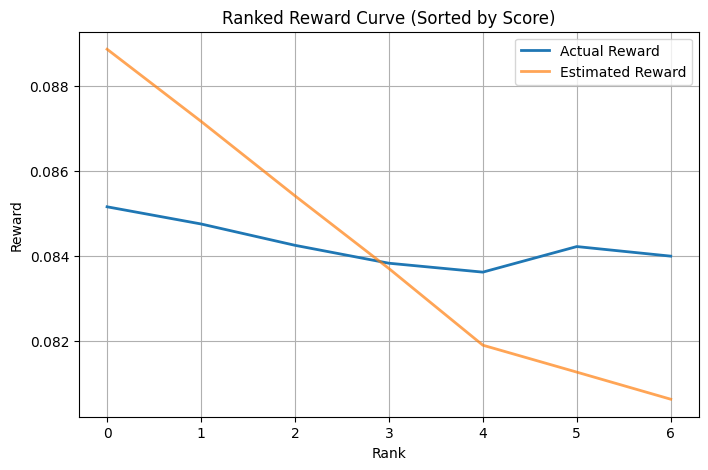

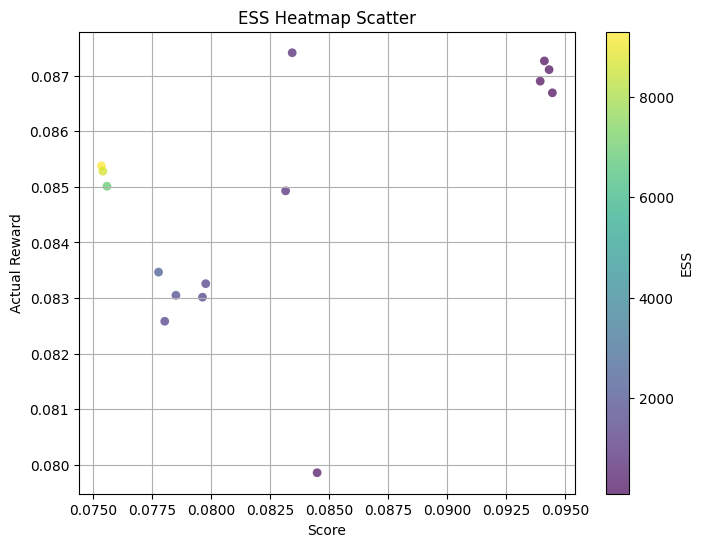

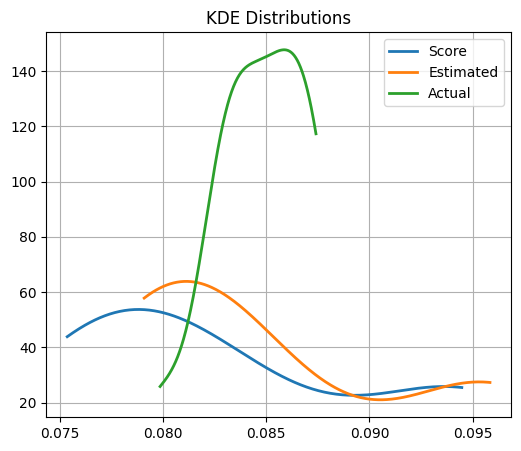

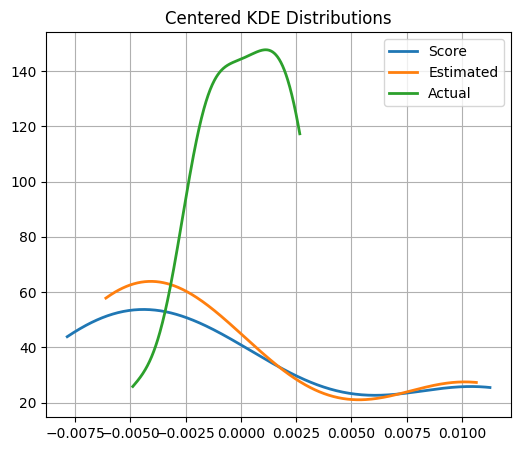

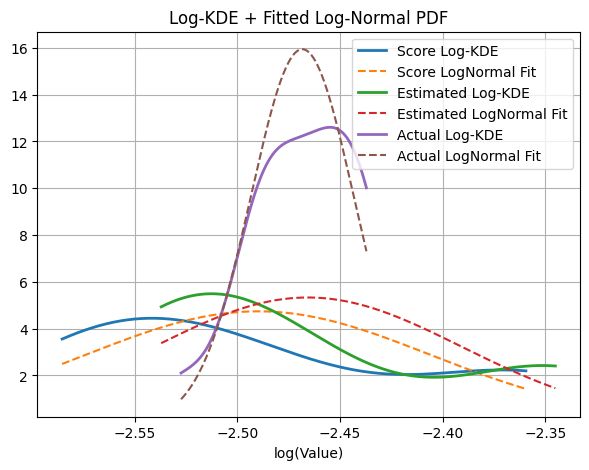

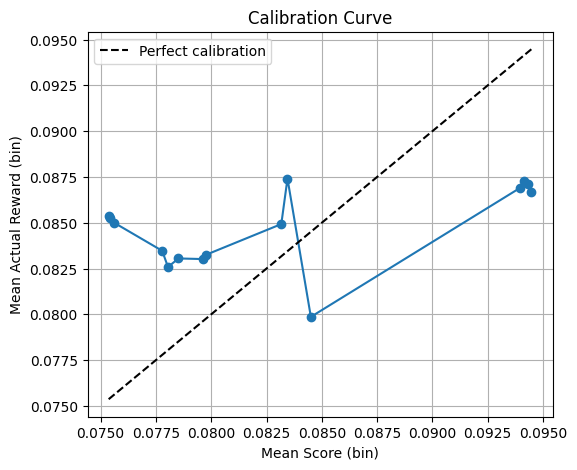

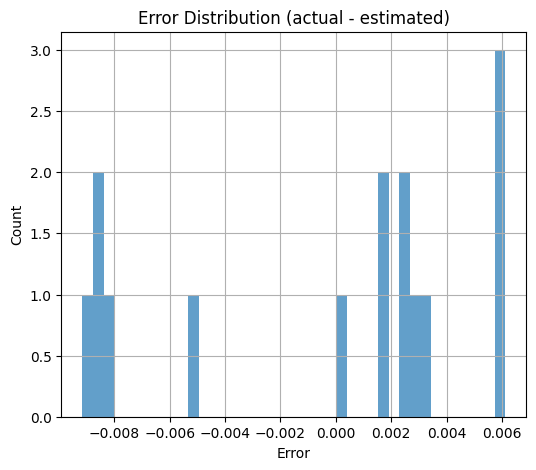

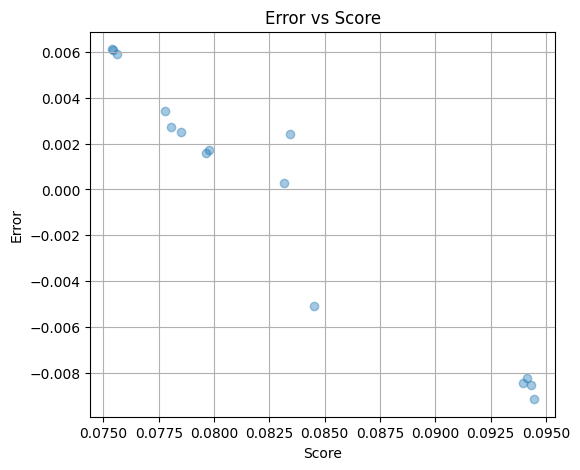

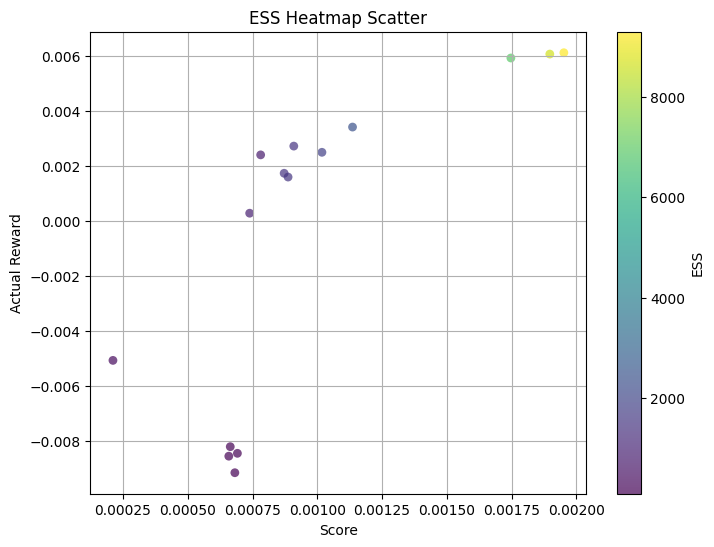

Correlation Metrics: {'pearson_score_actual': np.float64(0.5273238657646757), 'spearman_score_actual': np.float64(0.3857142857142856), 'spearman_est_actual': np.float64(0.4642857142857142)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.996903020094216), 'ndcg_est_actual': np.float64(0.9974034563202877)}
Error Metrics: {'mean_error': np.float64(-0.0004453101632250702), 'mae': np.float64(0.004808429511808526), 'rmse': np.float64(0.005577749389767212), 'std_error': np.float64(0.005559944884041295), 'max_error': np.float64(0.006111279326529051), 'min_error': np.float64(-0.009147302240054625)}


In [23]:
compute_statistics_and_plots(study_df5)

In [24]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=20000)

Random Item CTR: 0.07042251854546815
Optimal greedy CTR: 0.09999934264692525
Second Best greedy CTR: 0.09938443255799592
Optimal Stochastic CTR: 0.09996075464321043
second Best Stochastic CTR: 0.08632684639469405
Our Initial CTR: 0.08647580588501355


In [25]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df6.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{20000}.csv")
# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.0839388370513916 seconds
[Regression] Baseline regression model fit time: 0.02s
Num samples is 10000
{'gini': np.float64(0.46371986358162304), 'ess': np.float64(4549.756469284444), 'max_wi': np.float64(22.378442876700944), 'min_wi': np.float64(0.012898594037105757)}
Eval time: 0.6730716228485107 seconds


[I 2025-12-09 10:38:45,268] A new study created in memory with name: no-name-6f37e1f2-6646-4946-b58e-f8fa51770d73


Evaluation total results time: 1.09 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.06338000297546387 seconds


  0%|          | 0/27 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.0818442]
Validation weights_info: {'gini': np.float64(0.9922468622213104), 'ess': np.float64(68.83958022448734), 'max_wi': np.float64(590.6737626821708), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   4%|▎         | 1/27 [00:03<01:37,  3.77s/it]

[I 2025-12-09 10:38:49,036] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.08697848]
Validation weights_info: {'gini': np.float64(0.2157737350404124), 'ess': np.float64(8521.31307132319), 'max_wi': np.float64(3.0148493453633716), 'min_wi': np.float64(0.29727399920007896)}


Best trial: 1. Best value: 0.0797019:   7%|▋         | 2/27 [00:07<01:40,  4.03s/it]

[I 2025-12-09 10:38:53,257] Trial 1 finished with value: 0.07970185425638646 and parameters: {'lr': 0.00034520872602610285, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9096072389660637}. Best is trial 1 with value: 0.07970185425638646.

[Regression] Optuna Trial 2
actual reward: [0.08727795]
Validation weights_info: {'gini': np.float64(0.33542249520523415), 'ess': np.float64(6672.845695251231), 'max_wi': np.float64(6.352894076466786), 'min_wi': np.float64(0.14450194361297058)}


Best trial: 2. Best value: 0.0809252:  11%|█         | 3/27 [00:11<01:28,  3.68s/it]

[I 2025-12-09 10:38:56,509] Trial 2 finished with value: 0.08092515133760263 and parameters: {'lr': 0.0007839557682790905, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8558120122846161}. Best is trial 2 with value: 0.08092515133760263.

[Regression] Optuna Trial 3
actual reward: [0.08677786]
Validation weights_info: {'gini': np.float64(0.9908400140159065), 'ess': np.float64(88.86793949391779), 'max_wi': np.float64(418.68288355666067), 'min_wi': np.float64(5.371049391551934e-36)}


Best trial: 2. Best value: 0.0809252:  15%|█▍        | 4/27 [00:17<01:50,  4.78s/it]

[I 2025-12-09 10:39:02,990] Trial 3 finished with value: -inf and parameters: {'lr': 0.05501017107546131, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9119405834057754}. Best is trial 2 with value: 0.08092515133760263.

[Regression] Optuna Trial 4
actual reward: [0.08658151]
Validation weights_info: {'gini': np.float64(0.04759357729873986), 'ess': np.float64(9926.486748995656), 'max_wi': np.float64(1.2984938274756541), 'min_wi': np.float64(0.7860489699237238)}


Best trial: 2. Best value: 0.0809252:  19%|█▊        | 5/27 [00:21<01:38,  4.46s/it]

[I 2025-12-09 10:39:06,865] Trial 4 finished with value: 0.07832109375405688 and parameters: {'lr': 0.00010374509364487116, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.822562887864677}. Best is trial 2 with value: 0.08092515133760263.

[Regression] Optuna Trial 5
actual reward: [0.08663541]
Validation weights_info: {'gini': np.float64(0.06756442135101044), 'ess': np.float64(9850.602578949518), 'max_wi': np.float64(1.4149938350694093), 'min_wi': np.float64(0.7093007362690723)}


Best trial: 2. Best value: 0.0809252:  22%|██▏       | 6/27 [00:22<01:11,  3.38s/it]

[I 2025-12-09 10:39:08,159] Trial 5 finished with value: 0.07845401123944275 and parameters: {'lr': 0.0017334806240901718, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9368210055715535}. Best is trial 2 with value: 0.08092515133760263.

[Regression] Optuna Trial 6
actual reward: [0.09047239]
Validation weights_info: {'gini': np.float64(0.9497595624399241), 'ess': np.float64(220.25159627261579), 'max_wi': np.float64(324.60164776910045), 'min_wi': np.float64(5.331365075792072e-06)}


Best trial: 6. Best value: 0.0892631:  26%|██▌       | 7/27 [00:25<01:05,  3.26s/it]

[I 2025-12-09 10:39:11,166] Trial 6 finished with value: 0.08926309138388965 and parameters: {'lr': 0.005045893340317599, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9205417543330212}. Best is trial 6 with value: 0.08926309138388965.

[Regression] Optuna Trial 7
actual reward: [0.09015795]
Validation weights_info: {'gini': np.float64(0.9195999594691706), 'ess': np.float64(367.3194818305847), 'max_wi': np.float64(87.77245422899992), 'min_wi': np.float64(3.7427131634908234e-05)}


Best trial: 7. Best value: 0.0904063:  30%|██▉       | 8/27 [00:28<00:57,  3.04s/it]

[I 2025-12-09 10:39:13,740] Trial 7 finished with value: 0.09040625941045506 and parameters: {'lr': 0.0035890229635149895, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9560423045914026}. Best is trial 7 with value: 0.09040625941045506.

[Regression] Optuna Trial 8
actual reward: [0.08924133]
Validation weights_info: {'gini': np.float64(0.8241019582860639), 'ess': np.float64(796.6620124458792), 'max_wi': np.float64(64.64869107340662), 'min_wi': np.float64(0.0009164690716770237)}


Best trial: 7. Best value: 0.0904063:  33%|███▎      | 9/27 [00:34<01:12,  4.05s/it]

[I 2025-12-09 10:39:20,020] Trial 8 finished with value: 0.08775486955687242 and parameters: {'lr': 0.0018386058178505333, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8190019850861293}. Best is trial 7 with value: 0.09040625941045506.

[Regression] Optuna Trial 9
actual reward: [0.08667498]
Validation weights_info: {'gini': np.float64(0.08808674003987843), 'ess': np.float64(9745.898272133021), 'max_wi': np.float64(1.6311573576341625), 'min_wi': np.float64(0.6268170688103837)}


Best trial: 7. Best value: 0.0904063:  37%|███▋      | 10/27 [00:38<01:06,  3.92s/it]

[I 2025-12-09 10:39:23,640] Trial 9 finished with value: 0.07859027854649835 and parameters: {'lr': 0.0001557633244692353, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9048855929399033}. Best is trial 7 with value: 0.09040625941045506.

[Regression] Optuna Trial 10
actual reward: [0.09032081]
Validation weights_info: {'gini': np.float64(0.9491596176212309), 'ess': np.float64(270.96254127065026), 'max_wi': np.float64(191.75388664243445), 'min_wi': np.float64(2.058641713700439e-06)}


Best trial: 10. Best value: 0.091319:  41%|████      | 11/27 [00:40<00:51,  3.23s/it]

[I 2025-12-09 10:39:25,323] Trial 10 finished with value: 0.091319040649968 and parameters: {'lr': 0.011889602163230026, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9976408862234725}. Best is trial 10 with value: 0.091319040649968.

[Regression] Optuna Trial 11
actual reward: [0.08941676]
Validation weights_info: {'gini': np.float64(0.8820133418318921), 'ess': np.float64(446.04675118054837), 'max_wi': np.float64(86.6456717627097), 'min_wi': np.float64(9.163627157519251e-05)}


Best trial: 10. Best value: 0.091319:  44%|████▍     | 12/27 [00:41<00:40,  2.70s/it]

[I 2025-12-09 10:39:26,802] Trial 11 finished with value: 0.09017597773726023 and parameters: {'lr': 0.010882570838233982, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9900738268149354}. Best is trial 10 with value: 0.091319040649968.

[Regression] Optuna Trial 12
actual reward: [0.09135251]
Validation weights_info: {'gini': np.float64(0.9505124027261747), 'ess': np.float64(297.54445110678864), 'max_wi': np.float64(116.48422141479107), 'min_wi': np.float64(9.290955868344227e-06)}


Best trial: 10. Best value: 0.091319:  48%|████▊     | 13/27 [00:43<00:33,  2.39s/it]

[I 2025-12-09 10:39:28,470] Trial 12 finished with value: 0.0903473295836371 and parameters: {'lr': 0.012866633699412412, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9809287876690789}. Best is trial 10 with value: 0.091319040649968.

[Regression] Optuna Trial 13
actual reward: [0.08350668]
Validation weights_info: {'gini': np.float64(0.9947052862544306), 'ess': np.float64(10.310487124324109), 'max_wi': np.float64(2328.3425894071233), 'min_wi': np.float64(2.1009596787620865e-09)}


Best trial: 10. Best value: 0.091319:  52%|█████▏    | 14/27 [00:44<00:28,  2.17s/it]

[I 2025-12-09 10:39:30,124] Trial 13 finished with value: -inf and parameters: {'lr': 0.02436637418366791, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9605747541478167}. Best is trial 10 with value: 0.091319040649968.

[Regression] Optuna Trial 14
actual reward: [0.09025766]
Validation weights_info: {'gini': np.float64(0.9371487343253214), 'ess': np.float64(332.8614360743775), 'max_wi': np.float64(87.12072889769594), 'min_wi': np.float64(1.4965456602789295e-05)}


Best trial: 10. Best value: 0.091319:  56%|█████▌    | 15/27 [00:47<00:27,  2.26s/it]

[I 2025-12-09 10:39:32,587] Trial 14 finished with value: 0.09066129483570715 and parameters: {'lr': 0.004539133619113594, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9610314492948988}. Best is trial 10 with value: 0.091319040649968.

[Regression] Optuna Trial 15
actual reward: [0.08255348]
Validation weights_info: {'gini': np.float64(0.9911230345364106), 'ess': np.float64(9.243395018098521), 'max_wi': np.float64(2351.780535065953), 'min_wi': np.float64(1.2276610677087495e-08)}


Best trial: 10. Best value: 0.091319:  59%|█████▉    | 16/27 [00:49<00:25,  2.28s/it]

[I 2025-12-09 10:39:34,920] Trial 15 finished with value: -inf and parameters: {'lr': 0.009530133511793406, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9987555148684752}. Best is trial 10 with value: 0.091319040649968.

[Regression] Optuna Trial 16
actual reward: [0.09209351]
Validation weights_info: {'gini': np.float64(0.9784614035711439), 'ess': np.float64(191.57113664847344), 'max_wi': np.float64(137.12025401787648), 'min_wi': np.float64(3.7594889130001996e-08)}


Best trial: 16. Best value: 0.0920779:  63%|██████▎   | 17/27 [00:51<00:20,  2.09s/it]

[I 2025-12-09 10:39:36,586] Trial 16 finished with value: 0.09207790216454362 and parameters: {'lr': 0.02687441237683289, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9696335373502416}. Best is trial 16 with value: 0.09207790216454362.

[Regression] Optuna Trial 17
actual reward: [0.09163546]
Validation weights_info: {'gini': np.float64(0.9745976557307271), 'ess': np.float64(215.44579648142755), 'max_wi': np.float64(101.03084055380057), 'min_wi': np.float64(2.0909305823509805e-07)}


Best trial: 16. Best value: 0.0920779:  67%|██████▋   | 18/27 [00:52<00:17,  1.93s/it]

[I 2025-12-09 10:39:38,147] Trial 17 finished with value: 0.0913221181912066 and parameters: {'lr': 0.031477791541230905, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8786837736229391}. Best is trial 16 with value: 0.09207790216454362.

[Regression] Optuna Trial 18
actual reward: [0.09071557]
Validation weights_info: {'gini': np.float64(0.983854019166439), 'ess': np.float64(169.3913634040366), 'max_wi': np.float64(150.67204103694286), 'min_wi': np.float64(2.210756639698094e-10)}


Best trial: 18. Best value: 0.0929337:  70%|███████   | 19/27 [00:54<00:14,  1.83s/it]

[I 2025-12-09 10:39:39,734] Trial 18 finished with value: 0.09293367677151033 and parameters: {'lr': 0.04479784442712461, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8775947284528767}. Best is trial 18 with value: 0.09293367677151033.

[Regression] Optuna Trial 19
actual reward: [0.08995811]
Validation weights_info: {'gini': np.float64(0.9877939174779397), 'ess': np.float64(126.53071995080091), 'max_wi': np.float64(234.61391116792046), 'min_wi': np.float64(2.2460015382842302e-15)}


Best trial: 19. Best value: 0.095:  74%|███████▍  | 20/27 [00:56<00:12,  1.75s/it]    

[I 2025-12-09 10:39:41,295] Trial 19 finished with value: 0.0950000070139967 and parameters: {'lr': 0.09063965319809625, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8806379442590256}. Best is trial 19 with value: 0.0950000070139967.

[Regression] Optuna Trial 20
actual reward: [0.08787429]
Validation weights_info: {'gini': np.float64(0.9861841806604235), 'ess': np.float64(146.53014363328077), 'max_wi': np.float64(209.6887972663039), 'min_wi': np.float64(1.4330826732176e-12)}


Best trial: 19. Best value: 0.095:  78%|███████▊  | 21/27 [00:57<00:10,  1.76s/it]

[I 2025-12-09 10:39:43,070] Trial 20 finished with value: 0.09112013801277137 and parameters: {'lr': 0.0670031377735049, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8808420520333275}. Best is trial 19 with value: 0.0950000070139967.

[Regression] Optuna Trial 21
actual reward: [0.09140521]
Validation weights_info: {'gini': np.float64(0.9815387585793341), 'ess': np.float64(192.72755730701672), 'max_wi': np.float64(130.0665640886914), 'min_wi': np.float64(1.820342480819436e-10)}


Best trial: 19. Best value: 0.095:  81%|████████▏ | 22/27 [00:59<00:08,  1.73s/it]

[I 2025-12-09 10:39:44,725] Trial 21 finished with value: 0.09333744556753643 and parameters: {'lr': 0.0436457677829961, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8840167311172976}. Best is trial 19 with value: 0.0950000070139967.

[Regression] Optuna Trial 22
actual reward: [0.08720857]
Validation weights_info: {'gini': np.float64(0.984843164595496), 'ess': np.float64(159.4686679564104), 'max_wi': np.float64(142.91961356204808), 'min_wi': np.float64(3.4872083893109114e-10)}


Best trial: 19. Best value: 0.095:  85%|████████▌ | 23/27 [01:01<00:06,  1.69s/it]

[I 2025-12-09 10:39:46,322] Trial 22 finished with value: 0.09403173799647903 and parameters: {'lr': 0.04147442112192113, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8784989564827344}. Best is trial 19 with value: 0.0950000070139967.

[Regression] Optuna Trial 23
actual reward: [0.07644173]
Validation weights_info: {'gini': np.float64(0.9962150068803062), 'ess': np.float64(12.584897730897099), 'max_wi': np.float64(2636.3453091218876), 'min_wi': np.float64(7.518041797351431e-17)}


Best trial: 19. Best value: 0.095:  89%|████████▉ | 24/27 [01:03<00:05,  1.86s/it]

[I 2025-12-09 10:39:48,592] Trial 23 finished with value: -inf and parameters: {'lr': 0.08439971747513526, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8542975817956757}. Best is trial 19 with value: 0.0950000070139967.

[Regression] Optuna Trial 24
actual reward: [0.08951113]
Validation weights_info: {'gini': np.float64(0.881569721616946), 'ess': np.float64(477.63835970288073), 'max_wi': np.float64(84.52490724666795), 'min_wi': np.float64(0.0002526916487722436)}


Best trial: 19. Best value: 0.095:  93%|█████████▎| 25/27 [01:04<00:03,  1.72s/it]

[I 2025-12-09 10:39:49,966] Trial 24 finished with value: 0.09042939701481889 and parameters: {'lr': 0.017960168946391325, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.889810211725228}. Best is trial 19 with value: 0.0950000070139967.

[Regression] Optuna Trial 25
actual reward: [0.0903022]
Validation weights_info: {'gini': np.float64(0.9849614803816381), 'ess': np.float64(152.1734773119336), 'max_wi': np.float64(191.404456776094), 'min_wi': np.float64(3.562336637628646e-10)}


Best trial: 19. Best value: 0.095:  96%|█████████▋| 26/27 [01:06<00:01,  1.77s/it]

[I 2025-12-09 10:39:51,859] Trial 25 finished with value: 0.09216151348700326 and parameters: {'lr': 0.04646421969520773, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8456354593066181}. Best is trial 19 with value: 0.0950000070139967.

[Regression] Optuna Trial 26
actual reward: [0.09202832]
Validation weights_info: {'gini': np.float64(0.9832437458078357), 'ess': np.float64(109.22851480802356), 'max_wi': np.float64(690.5596328354077), 'min_wi': np.float64(7.466368465623656e-10)}


Best trial: 19. Best value: 0.095: 100%|██████████| 27/27 [01:08<00:00,  2.53s/it]


[I 2025-12-09 10:39:53,595] Trial 26 finished with value: 0.09198206042802826 and parameters: {'lr': 0.03513408044820609, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9313271772042546}. Best is trial 19 with value: 0.0950000070139967.
Num samples is 10000
{'gini': np.float64(0.9981687835584537), 'ess': np.float64(13.069189502909694), 'max_wi': np.float64(1293.0109423127549), 'min_wi': np.float64(6.184479379491139e-31)}
Eval time: 0.452176570892334 seconds
Evaluation total results time: 0.81 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08647581,0.08700000,0.08714365,0.08714365,0.08714203,0.08714203,0.88083979,0.00000000,0.74725465,0.00000000
15000,0.08647386,0.13247161,0.09146305,0.09146305,0.13832221,0.12671467,1.22046160,0.69116569,1.06107100,0.71765189


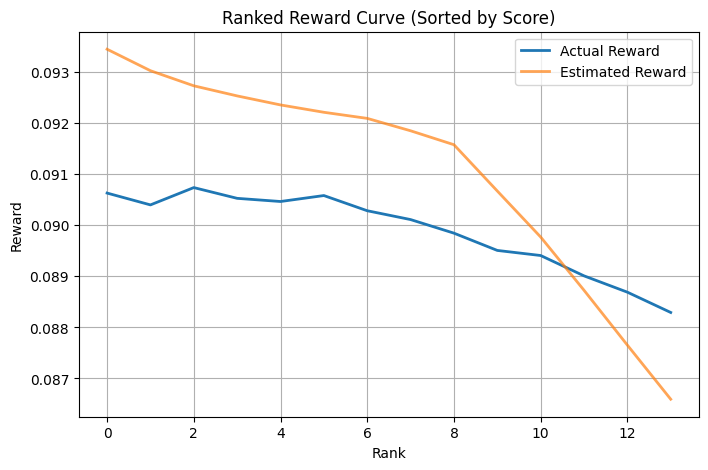

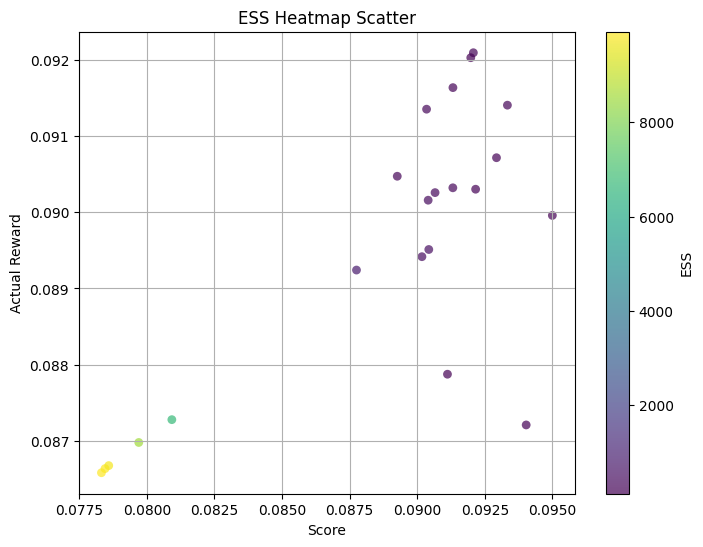

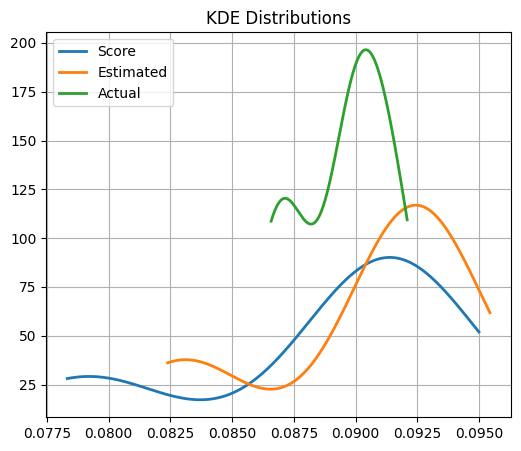

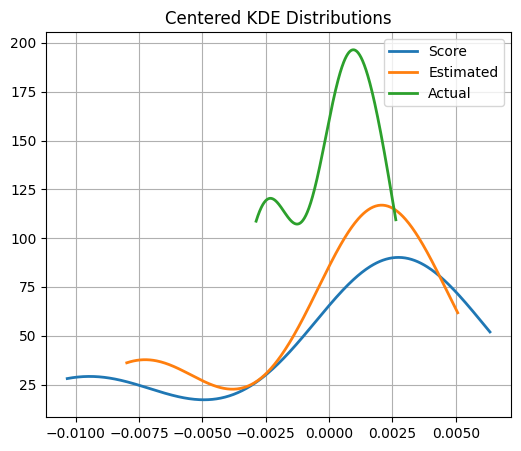

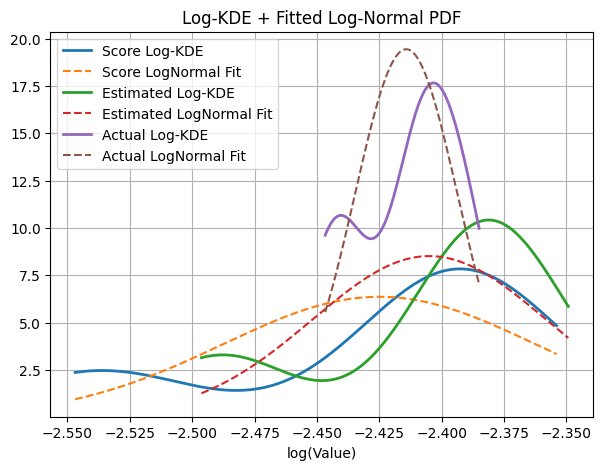

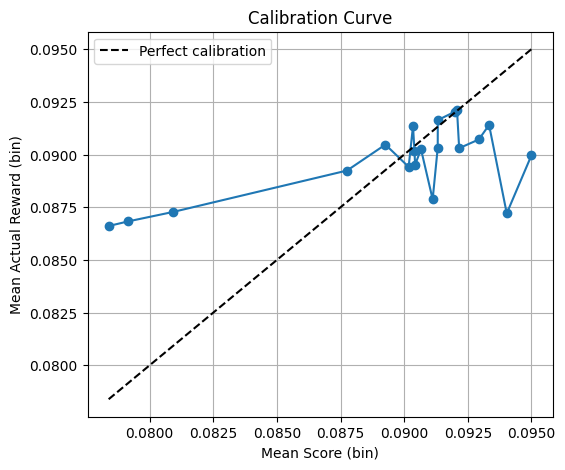

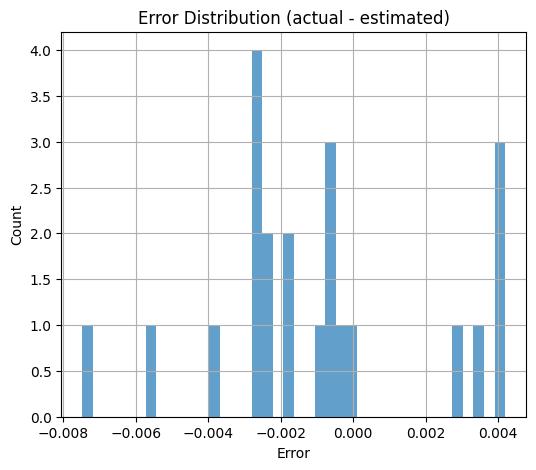

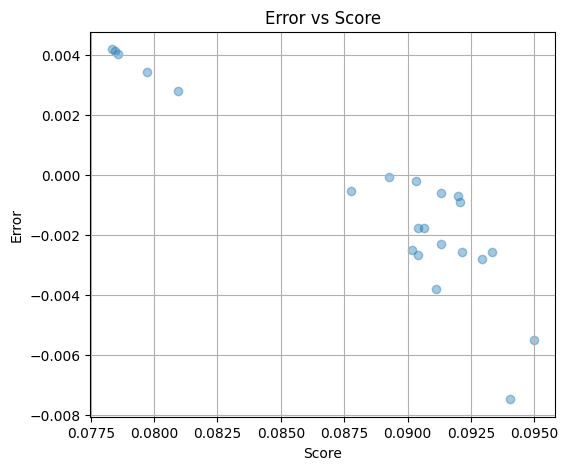

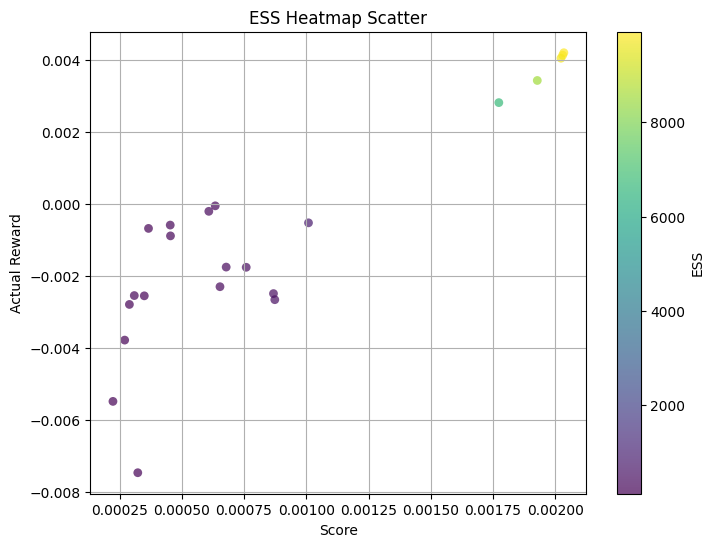

Correlation Metrics: {'pearson_score_actual': np.float64(0.7537186679505329), 'spearman_score_actual': np.float64(0.6137775268210052), 'spearman_est_actual': np.float64(0.6216826651609261)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9946239725874582), 'ndcg_est_actual': np.float64(0.9947506497364239)}
Error Metrics: {'mean_error': np.float64(-0.0009107948589365697), 'mae': np.float64(0.002600007784748858), 'rmse': np.float64(0.0031508614873233124), 'std_error': np.float64(0.0030163522402451588), 'max_error': np.float64(0.0041918597844696065), 'min_error': np.float64(-0.007469602568617895)}


In [26]:
compute_statistics_and_plots(study_df6)

In [27]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=30000)

Random Item CTR: 0.07069350185865088
Optimal greedy CTR: 0.09999918303816259
Second Best greedy CTR: 0.09988806364453348
Optimal Stochastic CTR: 0.0999509448932121
second Best Stochastic CTR: 0.0863879153702632
Our Initial CTR: 0.08653966603258505


In [28]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df7.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{30000}.csv")
# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.06829428672790527 seconds
[Regression] Baseline regression model fit time: 0.03s
Num samples is 10000
{'gini': np.float64(0.4667693221796617), 'ess': np.float64(4468.221320530572), 'max_wi': np.float64(22.52964963451592), 'min_wi': np.float64(0.010017672664738776)}
Eval time: 0.6545429229736328 seconds


[I 2025-12-09 10:39:58,561] A new study created in memory with name: no-name-42ac4f65-26e2-4708-9487-b28d04da71c5


Evaluation total results time: 1.04 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.0656137466430664 seconds


  0%|          | 0/27 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.0848104]
Validation weights_info: {'gini': np.float64(0.9919122008048177), 'ess': np.float64(88.08116835422172), 'max_wi': np.float64(258.1999596623511), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   4%|▎         | 1/27 [00:03<01:35,  3.68s/it]

[I 2025-12-09 10:40:02,243] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.09239149]
Validation weights_info: {'gini': np.float64(0.9332868923170758), 'ess': np.float64(358.34830719703837), 'max_wi': np.float64(197.31623809906986), 'min_wi': np.float64(1.8900477917982145e-05)}


Best trial: 1. Best value: 0.0808902:   7%|▋         | 2/27 [00:08<01:52,  4.52s/it]

[I 2025-12-09 10:40:07,345] Trial 1 finished with value: 0.08089019472269404 and parameters: {'lr': 0.0025871302699881304, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9504041659598729}. Best is trial 1 with value: 0.08089019472269404.

[Regression] Optuna Trial 2
actual reward: [0.08685577]
Validation weights_info: {'gini': np.float64(0.09761258152588065), 'ess': np.float64(9674.48697557763), 'max_wi': np.float64(1.6965692056873114), 'min_wi': np.float64(0.5937378580596837)}


Best trial: 1. Best value: 0.0808902:  11%|█         | 3/27 [00:12<01:40,  4.17s/it]

[I 2025-12-09 10:40:11,110] Trial 2 finished with value: 0.07693336729518113 and parameters: {'lr': 0.00016787511208185714, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9838553170331071}. Best is trial 1 with value: 0.08089019472269404.

[Regression] Optuna Trial 3
actual reward: [0.0896115]
Validation weights_info: {'gini': np.float64(0.9800594931361741), 'ess': np.float64(81.50982768614249), 'max_wi': np.float64(693.3822270734454), 'min_wi': np.float64(2.05797634734281e-09)}


Best trial: 1. Best value: 0.0808902:  15%|█▍        | 4/27 [00:16<01:37,  4.23s/it]

[I 2025-12-09 10:40:15,415] Trial 3 finished with value: -inf and parameters: {'lr': 0.009563254658769494, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.812170397594784}. Best is trial 1 with value: 0.08089019472269404.

[Regression] Optuna Trial 4
actual reward: [0.08727484]
Validation weights_info: {'gini': np.float64(0.22907153283966392), 'ess': np.float64(8285.319228701082), 'max_wi': np.float64(3.245863802302817), 'min_wi': np.float64(0.30649223004276355)}


Best trial: 1. Best value: 0.0808902:  19%|█▊        | 5/27 [00:18<01:13,  3.36s/it]

[I 2025-12-09 10:40:17,246] Trial 4 finished with value: 0.07731821035349755 and parameters: {'lr': 0.0014829619821773003, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9280081428320053}. Best is trial 1 with value: 0.08089019472269404.

[Regression] Optuna Trial 5
actual reward: [0.0865837]
Validation weights_info: {'gini': np.float64(0.013770185732853213), 'ess': np.float64(9993.66516815528), 'max_wi': np.float64(1.0802471274802647), 'min_wi': np.float64(0.9373344498172338)}


Best trial: 1. Best value: 0.0808902:  22%|██▏       | 6/27 [00:20<00:59,  2.84s/it]

[I 2025-12-09 10:40:19,059] Trial 5 finished with value: 0.07678582142940302 and parameters: {'lr': 0.0001103586549298271, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8228564832257318}. Best is trial 1 with value: 0.08089019472269404.

[Regression] Optuna Trial 6
actual reward: [0.08913834]
Validation weights_info: {'gini': np.float64(0.7159241554633075), 'ess': np.float64(1825.4426401435815), 'max_wi': np.float64(32.38714025782438), 'min_wi': np.float64(0.008544878790676)}


Best trial: 1. Best value: 0.0808902:  26%|██▌       | 7/27 [00:22<00:50,  2.52s/it]

[I 2025-12-09 10:40:20,915] Trial 6 finished with value: 0.07929568980751256 and parameters: {'lr': 0.005095674822946644, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9774195395273687}. Best is trial 1 with value: 0.08089019472269404.

[Regression] Optuna Trial 7
actual reward: [0.08702508]
Validation weights_info: {'gini': np.float64(0.9915352459051014), 'ess': np.float64(89.67948708840541), 'max_wi': np.float64(224.80781399612596), 'min_wi': np.float64(1.0368565537217045e-21)}


Best trial: 1. Best value: 0.0808902:  30%|██▉       | 8/27 [00:24<00:45,  2.39s/it]

[I 2025-12-09 10:40:23,030] Trial 7 finished with value: -inf and parameters: {'lr': 0.07683721504333432, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9889683735566994}. Best is trial 1 with value: 0.08089019472269404.

[Regression] Optuna Trial 8
actual reward: [0.09115346]
Validation weights_info: {'gini': np.float64(0.9798590428934881), 'ess': np.float64(162.5085638599294), 'max_wi': np.float64(251.53992039861384), 'min_wi': np.float64(1.6789287568094872e-07)}


Best trial: 8. Best value: 0.0819634:  33%|███▎      | 9/27 [00:26<00:41,  2.29s/it]

[I 2025-12-09 10:40:25,105] Trial 8 finished with value: 0.08196341461993881 and parameters: {'lr': 0.02154359489483512, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9016451447123578}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 9
actual reward: [0.09122961]
Validation weights_info: {'gini': np.float64(0.8971950208583138), 'ess': np.float64(555.920562105627), 'max_wi': np.float64(70.39036501402974), 'min_wi': np.float64(0.0002228132130440091)}


Best trial: 8. Best value: 0.0819634:  37%|███▋      | 10/27 [00:30<00:47,  2.81s/it]

[I 2025-12-09 10:40:29,088] Trial 9 finished with value: 0.07997250044748214 and parameters: {'lr': 0.00260243368041606, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9454762425902979}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 10
actual reward: [0.09131423]
Validation weights_info: {'gini': np.float64(0.9823941006652268), 'ess': np.float64(149.86564167663704), 'max_wi': np.float64(252.7953172276353), 'min_wi': np.float64(2.591145197119149e-08)}


Best trial: 8. Best value: 0.0819634:  41%|████      | 11/27 [00:33<00:43,  2.74s/it]

[I 2025-12-09 10:40:31,656] Trial 10 finished with value: 0.08003648896702083 and parameters: {'lr': 0.019647452004567745, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8806619282344514}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 11
actual reward: [0.08696646]
Validation weights_info: {'gini': np.float64(0.12792008253364526), 'ess': np.float64(9441.426674469558), 'max_wi': np.float64(1.9246489563829703), 'min_wi': np.float64(0.5283200248326917)}


Best trial: 8. Best value: 0.0819634:  44%|████▍     | 12/27 [00:35<00:39,  2.66s/it]

[I 2025-12-09 10:40:34,150] Trial 11 finished with value: 0.07700303591764121 and parameters: {'lr': 0.0007301755999821231, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9051053876483209}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 12
actual reward: [0.09246223]
Validation weights_info: {'gini': np.float64(0.9896923358760769), 'ess': np.float64(47.8204955344983), 'max_wi': np.float64(919.5316852609358), 'min_wi': np.float64(2.2056201086323522e-16)}


Best trial: 8. Best value: 0.0819634:  48%|████▊     | 13/27 [00:40<00:47,  3.36s/it]

[I 2025-12-09 10:40:39,126] Trial 12 finished with value: -inf and parameters: {'lr': 0.021126268182544806, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.937949012385246}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 13
actual reward: [0.08686517]
Validation weights_info: {'gini': np.float64(0.09743364043499879), 'ess': np.float64(9675.112174159265), 'max_wi': np.float64(1.6584673118910986), 'min_wi': np.float64(0.6280181034938045)}


Best trial: 8. Best value: 0.0819634:  52%|█████▏    | 14/27 [00:42<00:38,  3.00s/it]

[I 2025-12-09 10:40:41,278] Trial 13 finished with value: 0.07696317472663058 and parameters: {'lr': 0.0005439169260730571, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.889100492839596}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 14
actual reward: [0.09229965]
Validation weights_info: {'gini': np.float64(0.9926838876733973), 'ess': np.float64(20.614425632524625), 'max_wi': np.float64(1834.7198559792585), 'min_wi': np.float64(1.96636722541682e-14)}


Best trial: 8. Best value: 0.0819634:  56%|█████▌    | 15/27 [00:49<00:48,  4.05s/it]

[I 2025-12-09 10:40:47,781] Trial 14 finished with value: -inf and parameters: {'lr': 0.013735961822104615, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9580675723346971}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 15
actual reward: [0.09132529]
Validation weights_info: {'gini': np.float64(0.9866015758743325), 'ess': np.float64(123.71918789927305), 'max_wi': np.float64(281.5530679369538), 'min_wi': np.float64(3.4260076711661713e-10)}


Best trial: 8. Best value: 0.0819634:  59%|█████▉    | 16/27 [00:51<00:37,  3.37s/it]

[I 2025-12-09 10:40:49,570] Trial 15 finished with value: 0.08148352605986496 and parameters: {'lr': 0.04072282202130652, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9145747484606684}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 16
actual reward: [0.09149937]
Validation weights_info: {'gini': np.float64(0.9840955079126927), 'ess': np.float64(151.15406316322864), 'max_wi': np.float64(275.1983567673204), 'min_wi': np.float64(6.647713305478186e-10)}


Best trial: 8. Best value: 0.0819634:  63%|██████▎   | 17/27 [00:52<00:27,  2.80s/it]

[I 2025-12-09 10:40:51,036] Trial 16 finished with value: 0.08119931039300773 and parameters: {'lr': 0.047646749647757544, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8621930194039569}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 17
actual reward: [0.09022319]
Validation weights_info: {'gini': np.float64(0.889400293510288), 'ess': np.float64(620.9175623917681), 'max_wi': np.float64(79.25774831826455), 'min_wi': np.float64(0.00012059475863634933)}


Best trial: 8. Best value: 0.0819634:  67%|██████▋   | 18/27 [00:53<00:20,  2.32s/it]

[I 2025-12-09 10:40:52,230] Trial 17 finished with value: 0.0796039190951289 and parameters: {'lr': 0.0374583336516613, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9164964015258644}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 18
actual reward: [0.08951142]
Validation weights_info: {'gini': np.float64(0.7516939698250431), 'ess': np.float64(1409.9407262891566), 'max_wi': np.float64(43.857773713689944), 'min_wi': np.float64(0.0066383711791345446)}


Best trial: 8. Best value: 0.0819634:  70%|███████   | 19/27 [00:55<00:17,  2.16s/it]

[I 2025-12-09 10:40:54,039] Trial 18 finished with value: 0.07932708720314918 and parameters: {'lr': 0.005879866036983372, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8699417599684602}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 19
actual reward: [0.09198593]
Validation weights_info: {'gini': np.float64(0.9776272998467315), 'ess': np.float64(159.75171328462883), 'max_wi': np.float64(235.1171876762304), 'min_wi': np.float64(7.670299428014502e-07)}


Best trial: 8. Best value: 0.0819634:  74%|███████▍  | 20/27 [00:56<00:13,  1.95s/it]

[I 2025-12-09 10:40:55,486] Trial 19 finished with value: 0.08170206368029352 and parameters: {'lr': 0.028407431666219354, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8354796353191294}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 20
actual reward: [0.09003529]
Validation weights_info: {'gini': np.float64(0.8158907055792854), 'ess': np.float64(1000.8254209917403), 'max_wi': np.float64(62.67223795580675), 'min_wi': np.float64(0.0024680475063513585)}


Best trial: 8. Best value: 0.0819634:  78%|███████▊  | 21/27 [00:58<00:10,  1.82s/it]

[I 2025-12-09 10:40:57,010] Trial 20 finished with value: 0.0798341509601372 and parameters: {'lr': 0.00999264135995006, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8385386594980982}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 21
actual reward: [0.09157186]
Validation weights_info: {'gini': np.float64(0.9825679348826124), 'ess': np.float64(147.49621252740147), 'max_wi': np.float64(251.67240166438708), 'min_wi': np.float64(7.481237910735834e-08)}


Best trial: 8. Best value: 0.0819634:  81%|████████▏ | 22/27 [00:59<00:08,  1.66s/it]

[I 2025-12-09 10:40:58,299] Trial 21 finished with value: 0.08185568868672895 and parameters: {'lr': 0.0338680940827527, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9022770474013081}. Best is trial 8 with value: 0.08196341461993881.

[Regression] Optuna Trial 22
actual reward: [0.09288722]
Validation weights_info: {'gini': np.float64(0.9759139307801952), 'ess': np.float64(192.30684898228685), 'max_wi': np.float64(176.62852714168514), 'min_wi': np.float64(1.3998907140672385e-07)}


Best trial: 22. Best value: 0.0822318:  85%|████████▌ | 23/27 [01:01<00:06,  1.62s/it]

[I 2025-12-09 10:40:59,812] Trial 22 finished with value: 0.0822317638371024 and parameters: {'lr': 0.02784146057686801, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8942092116199947}. Best is trial 22 with value: 0.0822317638371024.

[Regression] Optuna Trial 23
actual reward: [0.09050626]
Validation weights_info: {'gini': np.float64(0.9863390873849973), 'ess': np.float64(125.85700289468735), 'max_wi': np.float64(244.7880932779749), 'min_wi': np.float64(9.398531568754989e-12)}


Best trial: 23. Best value: 0.083574:  89%|████████▉ | 24/27 [01:02<00:04,  1.56s/it] 

[I 2025-12-09 10:41:01,223] Trial 23 finished with value: 0.08357400683155909 and parameters: {'lr': 0.05719552854062701, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8854095751961217}. Best is trial 23 with value: 0.08357400683155909.

[Regression] Optuna Trial 24
actual reward: [0.09160369]
Validation weights_info: {'gini': np.float64(0.9799597985929287), 'ess': np.float64(165.13892783938974), 'max_wi': np.float64(222.91766765326594), 'min_wi': np.float64(3.2403863400357144e-09)}


Best trial: 23. Best value: 0.083574:  93%|█████████▎| 25/27 [01:03<00:02,  1.43s/it]

[I 2025-12-09 10:41:02,363] Trial 24 finished with value: 0.08327810323597501 and parameters: {'lr': 0.059459816756358454, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8871784269071916}. Best is trial 23 with value: 0.08357400683155909.

[Regression] Optuna Trial 25
actual reward: [0.09132487]
Validation weights_info: {'gini': np.float64(0.9630524358316899), 'ess': np.float64(261.0471616345058), 'max_wi': np.float64(112.52894259289599), 'min_wi': np.float64(1.8127294168771892e-07)}


Best trial: 23. Best value: 0.083574:  96%|█████████▋| 26/27 [01:04<00:01,  1.28s/it]

[I 2025-12-09 10:41:03,276] Trial 25 finished with value: 0.08209810849257915 and parameters: {'lr': 0.06456970888057413, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8793989714729356}. Best is trial 23 with value: 0.08357400683155909.

[Regression] Optuna Trial 26
actual reward: [0.08877628]
Validation weights_info: {'gini': np.float64(0.9878523064062918), 'ess': np.float64(128.2242217235919), 'max_wi': np.float64(157.94860942793457), 'min_wi': np.float64(2.2575360624005148e-13)}


Best trial: 23. Best value: 0.083574: 100%|██████████| 27/27 [01:05<00:00,  2.44s/it]


[I 2025-12-09 10:41:04,423] Trial 26 finished with value: 0.08307060252470848 and parameters: {'lr': 0.0912996212816968, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.860442248601084}. Best is trial 23 with value: 0.08357400683155909.
Num samples is 10000
{'gini': np.float64(0.995031708210515), 'ess': np.float64(46.80492014397183), 'max_wi': np.float64(625.9084941414219), 'min_wi': np.float64(2.488939098411673e-16)}
Eval time: 0.5584530830383301 seconds
Evaluation total results time: 0.92 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08653967,0.08750000,0.08755154,0.08755154,0.08756895,0.08756895,0.82469903,0.00000000,0.72168239,0.00000000
15000,0.08801975,0.07769321,0.08345054,0.08345054,0.07864955,0.07851350,0.99572309,0.52747681,0.96055540,0.56992556


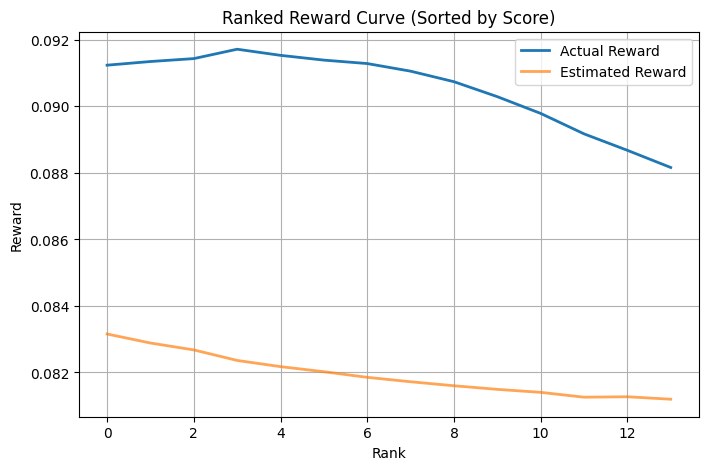

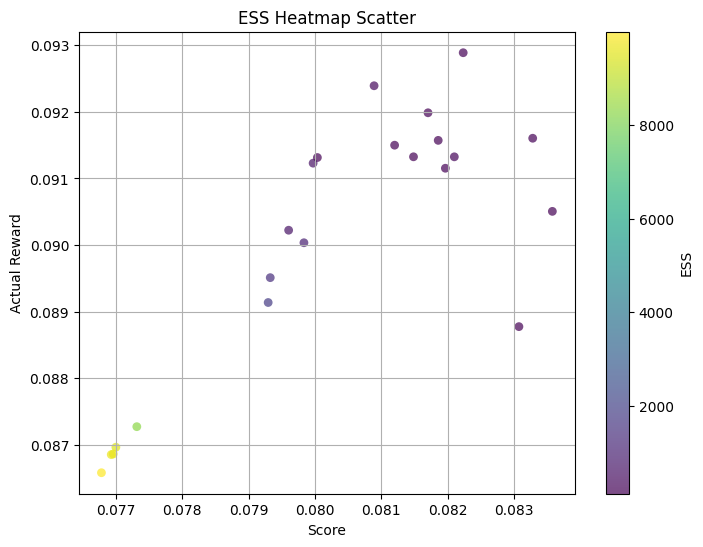

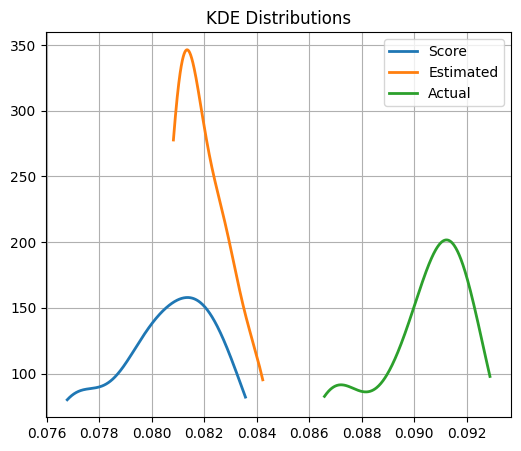

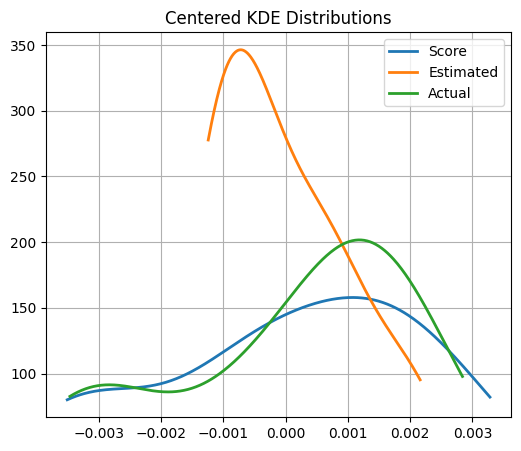

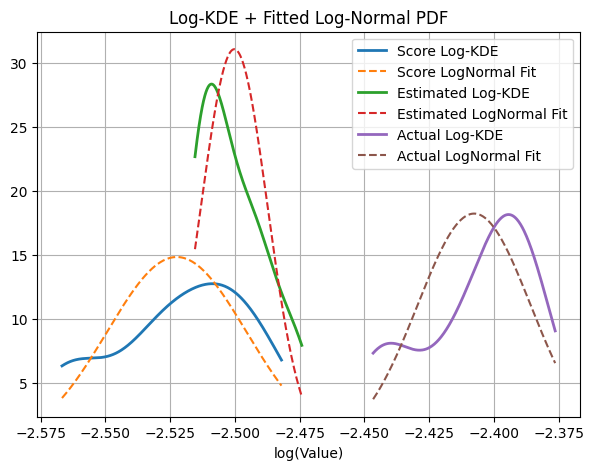

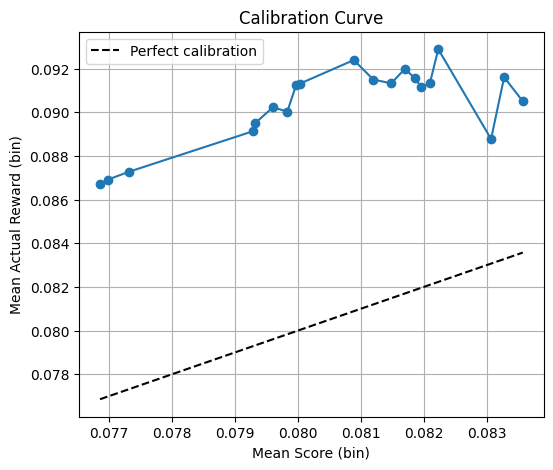

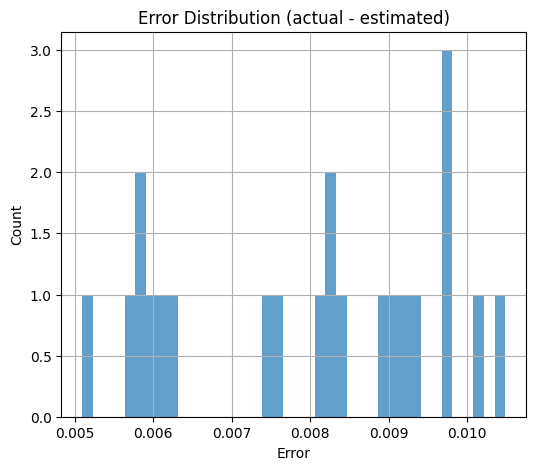

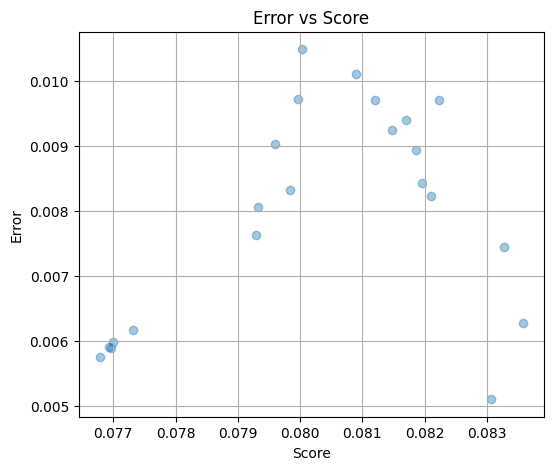

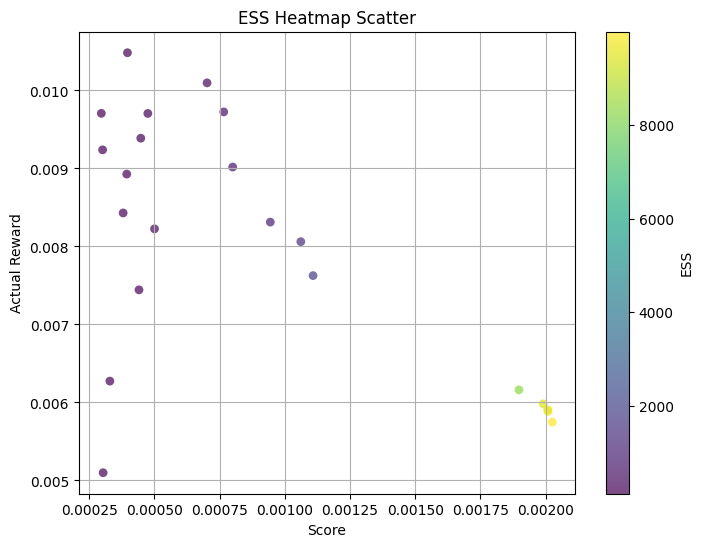

Correlation Metrics: {'pearson_score_actual': np.float64(0.8023562832473748), 'spearman_score_actual': np.float64(0.707509881422925), 'spearman_est_actual': np.float64(0.611518915866742)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9960582973836161), 'ndcg_est_actual': np.float64(0.9958585998944715)}
Error Metrics: {'mean_error': np.float64(0.007974843451621076), 'mae': np.float64(0.007974843451621076), 'rmse': np.float64(0.008139268205938032), 'std_error': np.float64(0.0016277465559263779), 'max_error': np.float64(0.010484282682803436), 'min_error': np.float64(0.0050987890976621625)}


In [29]:
compute_statistics_and_plots(study_df7)

In [30]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=40000)

Random Item CTR: 0.07053370144999074
Optimal greedy CTR: 0.09999936716169436
Second Best greedy CTR: 0.09676800930842865
Optimal Stochastic CTR: 0.09995563088920843
second Best Stochastic CTR: 0.08606322612964991
Our Initial CTR: 0.08622184481781218


In [31]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df8.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{40000}.csv")
# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.06797337532043457 seconds
[Regression] Baseline regression model fit time: 0.04s
Num samples is 10000
{'gini': np.float64(0.47055735905229645), 'ess': np.float64(4238.833294890685), 'max_wi': np.float64(37.72893704250068), 'min_wi': np.float64(0.008707370703380918)}
Eval time: 0.6676323413848877 seconds


[I 2025-12-09 10:41:09,148] A new study created in memory with name: no-name-44b3c5ca-a591-4ac9-abdb-f517243ef8c3


Evaluation total results time: 1.12 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.07198524475097656 seconds


  0%|          | 0/27 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08092439]
Validation weights_info: {'gini': np.float64(0.9898576368962417), 'ess': np.float64(59.328329591058925), 'max_wi': np.float64(980.5866145270957), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   4%|▎         | 1/27 [00:04<01:55,  4.46s/it]

[I 2025-12-09 10:41:13,606] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.08919105]
Validation weights_info: {'gini': np.float64(0.8664161789133471), 'ess': np.float64(799.2687605397936), 'max_wi': np.float64(76.525557182286), 'min_wi': np.float64(0.00034299611886300487)}


Best trial: 1. Best value: 0.0815094:   7%|▋         | 2/27 [00:10<02:11,  5.27s/it]

[I 2025-12-09 10:41:19,437] Trial 1 finished with value: 0.08150940799555766 and parameters: {'lr': 0.00103529441727443, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9604504505205638}. Best is trial 1 with value: 0.08150940799555766.

[Regression] Optuna Trial 2
actual reward: [0.0889581]
Validation weights_info: {'gini': np.float64(0.8967207908912073), 'ess': np.float64(575.7346348838935), 'max_wi': np.float64(59.716237364485096), 'min_wi': np.float64(6.761318334290933e-05)}


Best trial: 1. Best value: 0.0815094:  11%|█         | 3/27 [00:12<01:31,  3.82s/it]

[I 2025-12-09 10:41:21,542] Trial 2 finished with value: 0.08035291077370177 and parameters: {'lr': 0.005531992824197889, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9697905893203457}. Best is trial 1 with value: 0.08150940799555766.

[Regression] Optuna Trial 3
actual reward: [0.08679964]
Validation weights_info: {'gini': np.float64(0.3864325029365835), 'ess': np.float64(5819.886725128667), 'max_wi': np.float64(8.52657728724972), 'min_wi': np.float64(0.1860535721737425)}


Best trial: 1. Best value: 0.0815094:  15%|█▍        | 4/27 [00:13<01:05,  2.86s/it]

[I 2025-12-09 10:41:22,925] Trial 3 finished with value: 0.07751828825553583 and parameters: {'lr': 0.004387508253185937, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8737110754381685}. Best is trial 1 with value: 0.08150940799555766.

[Regression] Optuna Trial 4
actual reward: [0.08409341]
Validation weights_info: {'gini': np.float64(0.9901023613558135), 'ess': np.float64(20.180410355906766), 'max_wi': np.float64(1472.8999242813009), 'min_wi': np.float64(1.823704825213436e-21)}


Best trial: 1. Best value: 0.0815094:  19%|█▊        | 5/27 [00:19<01:23,  3.78s/it]

[I 2025-12-09 10:41:28,339] Trial 4 finished with value: -inf and parameters: {'lr': 0.025189025053413052, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9858839491894723}. Best is trial 1 with value: 0.08150940799555766.

[Regression] Optuna Trial 5
actual reward: [0.08628313]
Validation weights_info: {'gini': np.float64(0.04772078765425557), 'ess': np.float64(9924.170020073005), 'max_wi': np.float64(1.3388226776487329), 'min_wi': np.float64(0.8318648379128929)}


Best trial: 1. Best value: 0.0815094:  22%|██▏       | 6/27 [00:21<01:10,  3.33s/it]

[I 2025-12-09 10:41:30,809] Trial 5 finished with value: 0.0756628370069919 and parameters: {'lr': 0.00011141007970222037, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8976559634794523}. Best is trial 1 with value: 0.08150940799555766.

[Regression] Optuna Trial 6
actual reward: [0.08786841]
Validation weights_info: {'gini': np.float64(0.7386591594277832), 'ess': np.float64(1621.9777637448308), 'max_wi': np.float64(26.200577662153897), 'min_wi': np.float64(0.00616028423120687)}


Best trial: 1. Best value: 0.0815094:  26%|██▌       | 7/27 [00:26<01:13,  3.68s/it]

[I 2025-12-09 10:41:35,198] Trial 6 finished with value: 0.07990628364523107 and parameters: {'lr': 0.001142667468538919, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8660986978938567}. Best is trial 1 with value: 0.08150940799555766.

[Regression] Optuna Trial 7
actual reward: [0.08690126]
Validation weights_info: {'gini': np.float64(0.9860775541570079), 'ess': np.float64(110.79139162434576), 'max_wi': np.float64(260.6046819017188), 'min_wi': np.float64(1.2217521953816907e-14)}


Best trial: 7. Best value: 0.0869781:  30%|██▉       | 8/27 [00:28<01:01,  3.23s/it]

[I 2025-12-09 10:41:37,467] Trial 7 finished with value: 0.08697808723278436 and parameters: {'lr': 0.033583776435342515, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9214893253167971}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 8
actual reward: [0.0863226]
Validation weights_info: {'gini': np.float64(0.0732227242955362), 'ess': np.float64(9818.497418655967), 'max_wi': np.float64(1.5515683010397798), 'min_wi': np.float64(0.7733022165746644)}


Best trial: 7. Best value: 0.0869781:  33%|███▎      | 9/27 [00:31<00:55,  3.06s/it]

[I 2025-12-09 10:41:40,152] Trial 8 finished with value: 0.0757199172125688 and parameters: {'lr': 0.0003099977508083724, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8035730505262973}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 9
actual reward: [0.08705089]
Validation weights_info: {'gini': np.float64(0.47349481479718064), 'ess': np.float64(4406.224460573086), 'max_wi': np.float64(12.784070474063965), 'min_wi': np.float64(0.08731362089314224)}


Best trial: 7. Best value: 0.0869781:  37%|███▋      | 10/27 [00:34<00:54,  3.19s/it]

[I 2025-12-09 10:41:43,632] Trial 9 finished with value: 0.07827427215578936 and parameters: {'lr': 0.0007089304653091312, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.932815904883584}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 10
actual reward: [0.08789054]
Validation weights_info: {'gini': np.float64(0.9742239638860535), 'ess': np.float64(58.0476023946782), 'max_wi': np.float64(435.54877854663795), 'min_wi': np.float64(4.219787714802091e-06)}


Best trial: 7. Best value: 0.0869781:  41%|████      | 11/27 [00:35<00:42,  2.66s/it]

[I 2025-12-09 10:41:45,098] Trial 10 finished with value: -inf and parameters: {'lr': 0.02031355916625815, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.924574181594921}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 11
actual reward: [0.0900543]
Validation weights_info: {'gini': np.float64(0.9585115464036816), 'ess': np.float64(124.16802872791473), 'max_wi': np.float64(381.2630214910338), 'min_wi': np.float64(8.258156246204207e-07)}


Best trial: 7. Best value: 0.0869781:  44%|████▍     | 12/27 [00:42<00:58,  3.89s/it]

[I 2025-12-09 10:41:51,803] Trial 11 finished with value: 0.0847637634254863 and parameters: {'lr': 0.0017913702218069862, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9511881546606022}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 12
actual reward: [0.08926379]
Validation weights_info: {'gini': np.float64(0.9456770771008784), 'ess': np.float64(144.50811184452675), 'max_wi': np.float64(629.3756949230558), 'min_wi': np.float64(1.365396047206555e-05)}


Best trial: 7. Best value: 0.0869781:  48%|████▊     | 13/27 [00:44<00:44,  3.15s/it]

[I 2025-12-09 10:41:53,245] Trial 12 finished with value: 0.0818024594463301 and parameters: {'lr': 0.013413158873146496, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9375055479622292}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 13
actual reward: [0.08113454]
Validation weights_info: {'gini': np.float64(0.9943193158986168), 'ess': np.float64(22.5068132807454), 'max_wi': np.float64(1585.1364426036894), 'min_wi': np.float64(0.0)}


Best trial: 7. Best value: 0.0869781:  52%|█████▏    | 14/27 [00:49<00:50,  3.87s/it]

[I 2025-12-09 10:41:58,791] Trial 13 finished with value: -inf and parameters: {'lr': 0.09856534197860445, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9069285712208894}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 14
actual reward: [0.08854591]
Validation weights_info: {'gini': np.float64(0.8354027966183749), 'ess': np.float64(841.48206912035), 'max_wi': np.float64(75.8714536306069), 'min_wi': np.float64(0.0014759147902389305)}


Best trial: 7. Best value: 0.0869781:  56%|█████▌    | 15/27 [00:52<00:42,  3.55s/it]

[I 2025-12-09 10:42:01,606] Trial 14 finished with value: 0.08060758068047826 and parameters: {'lr': 0.002225230455838308, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9952957603143335}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 15
actual reward: [0.08706523]
Validation weights_info: {'gini': np.float64(0.9916902660385798), 'ess': np.float64(11.70645194627914), 'max_wi': np.float64(2331.150215187272), 'min_wi': np.float64(1.0432307667742468e-13)}


Best trial: 7. Best value: 0.0869781:  59%|█████▉    | 16/27 [00:57<00:43,  3.96s/it]

[I 2025-12-09 10:42:06,511] Trial 15 finished with value: -inf and parameters: {'lr': 0.011438930690825385, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9659630550207837}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 16
actual reward: [0.08115212]
Validation weights_info: {'gini': np.float64(0.998318912425644), 'ess': np.float64(9.136937197266727), 'max_wi': np.float64(1330.6046262694192), 'min_wi': np.float64(1.0831063728188472e-11)}


Best trial: 7. Best value: 0.0869781:  63%|██████▎   | 17/27 [00:59<00:35,  3.55s/it]

[I 2025-12-09 10:42:09,119] Trial 16 finished with value: -inf and parameters: {'lr': 0.040651082958513086, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9024596156780393}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 17
actual reward: [0.08753643]
Validation weights_info: {'gini': np.float64(0.6477626584417133), 'ess': np.float64(2139.748598480734), 'max_wi': np.float64(32.63853716570259), 'min_wi': np.float64(0.02283369798750796)}


Best trial: 7. Best value: 0.0869781:  67%|██████▋   | 18/27 [01:02<00:28,  3.14s/it]

[I 2025-12-09 10:42:11,278] Trial 17 finished with value: 0.0796289605239336 and parameters: {'lr': 0.002312496325932859, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9463517759330451}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 18
actual reward: [0.08922519]
Validation weights_info: {'gini': np.float64(0.9172784886032198), 'ess': np.float64(295.24484456531724), 'max_wi': np.float64(284.5083697386444), 'min_wi': np.float64(7.000786032079309e-05)}


Best trial: 7. Best value: 0.0869781:  70%|███████   | 19/27 [01:04<00:22,  2.79s/it]

[I 2025-12-09 10:42:13,274] Trial 18 finished with value: 0.08236158312208708 and parameters: {'lr': 0.007814112096743481, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.8172164666435592}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 19
actual reward: [0.08675014]
Validation weights_info: {'gini': np.float64(0.3379498503104743), 'ess': np.float64(6664.634869779958), 'max_wi': np.float64(6.300882989031963), 'min_wi': np.float64(0.21364519119566824)}


Best trial: 7. Best value: 0.0869781:  74%|███████▍  | 20/27 [01:09<00:24,  3.47s/it]

[I 2025-12-09 10:42:18,314] Trial 19 finished with value: 0.07728193798373963 and parameters: {'lr': 0.00033015557448824284, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9178750014455078}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 20
actual reward: [0.08437751]
Validation weights_info: {'gini': np.float64(0.9964332301732582), 'ess': np.float64(5.266225189841667), 'max_wi': np.float64(4281.631162402937), 'min_wi': np.float64(5.651134081592499e-24)}


Best trial: 7. Best value: 0.0869781:  78%|███████▊  | 21/27 [01:13<00:21,  3.59s/it]

[I 2025-12-09 10:42:22,200] Trial 20 finished with value: -inf and parameters: {'lr': 0.0463079761542551, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8899043423971795}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 21
actual reward: [0.08975057]
Validation weights_info: {'gini': np.float64(0.9205141539713777), 'ess': np.float64(352.87993762470586), 'max_wi': np.float64(176.00002301782112), 'min_wi': np.float64(8.823133464605902e-05)}


Best trial: 7. Best value: 0.0869781:  81%|████████▏ | 22/27 [01:14<00:15,  3.04s/it]

[I 2025-12-09 10:42:23,959] Trial 21 finished with value: 0.08291587992477223 and parameters: {'lr': 0.007869483436136814, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.8330935227245478}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 22
actual reward: [0.08723538]
Validation weights_info: {'gini': np.float64(0.5590754720507919), 'ess': np.float64(3042.7855753332074), 'max_wi': np.float64(24.459399844336932), 'min_wi': np.float64(0.05389552737843363)}


Best trial: 7. Best value: 0.0869781:  85%|████████▌ | 23/27 [01:16<00:10,  2.73s/it]

[I 2025-12-09 10:42:25,944] Trial 22 finished with value: 0.07893729744697041 and parameters: {'lr': 0.0024118861569242, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.8405566548565799}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 23
actual reward: [0.08812904]
Validation weights_info: {'gini': np.float64(0.9824848557695401), 'ess': np.float64(44.00615849281287), 'max_wi': np.float64(925.7592110676483), 'min_wi': np.float64(8.139458871162734e-07)}


Best trial: 7. Best value: 0.0869781:  89%|████████▉ | 24/27 [01:19<00:07,  2.66s/it]

[I 2025-12-09 10:42:28,450] Trial 23 finished with value: -inf and parameters: {'lr': 0.008301513962486457, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.952729652836177}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 24
actual reward: [0.08686362]
Validation weights_info: {'gini': np.float64(0.9939290685393783), 'ess': np.float64(8.512613549823747), 'max_wi': np.float64(2293.97605100666), 'min_wi': np.float64(3.0890324593447664e-14)}


Best trial: 7. Best value: 0.0869781:  93%|█████████▎| 25/27 [01:21<00:04,  2.46s/it]

[I 2025-12-09 10:42:30,434] Trial 24 finished with value: -inf and parameters: {'lr': 0.04095259886649991, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8312326592679523}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 25
actual reward: [0.08716678]
Validation weights_info: {'gini': np.float64(0.561017863045887), 'ess': np.float64(2841.200450725386), 'max_wi': np.float64(24.901820451070567), 'min_wi': np.float64(0.04970346201075936)}


Best trial: 7. Best value: 0.0869781:  96%|█████████▋| 26/27 [01:22<00:02,  2.15s/it]

[I 2025-12-09 10:42:31,870] Trial 25 finished with value: 0.07871900664457895 and parameters: {'lr': 0.004264763383791444, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.8784583347311019}. Best is trial 7 with value: 0.08697808723278436.

[Regression] Optuna Trial 26
actual reward: [0.0823122]
Validation weights_info: {'gini': np.float64(0.9976910120738), 'ess': np.float64(5.97694360314053), 'max_wi': np.float64(3133.436270929909), 'min_wi': np.float64(2.6384880130701405e-09)}


Best trial: 7. Best value: 0.0869781: 100%|██████████| 27/27 [01:25<00:00,  3.16s/it]


[I 2025-12-09 10:42:34,443] Trial 26 finished with value: -inf and parameters: {'lr': 0.016338588281991608, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8572879873686}. Best is trial 7 with value: 0.08697808723278436.
Num samples is 10000
{'gini': np.float64(0.9983434898519414), 'ess': np.float64(6.2691293086111095), 'max_wi': np.float64(1759.0881010174814), 'min_wi': np.float64(2.5743593325399902e-11)}
Eval time: 0.4645400047302246 seconds
Evaluation total results time: 0.86 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08622184,0.08660000,0.08668570,0.08668570,0.08667963,0.08667963,0.92210476,0.00000000,0.83772226,0.00000000
15000,0.08324746,0.04064114,0.09074550,0.09074550,0.06085784,0.03607607,1.06851033,0.40312043,0.99224325,0.35411117


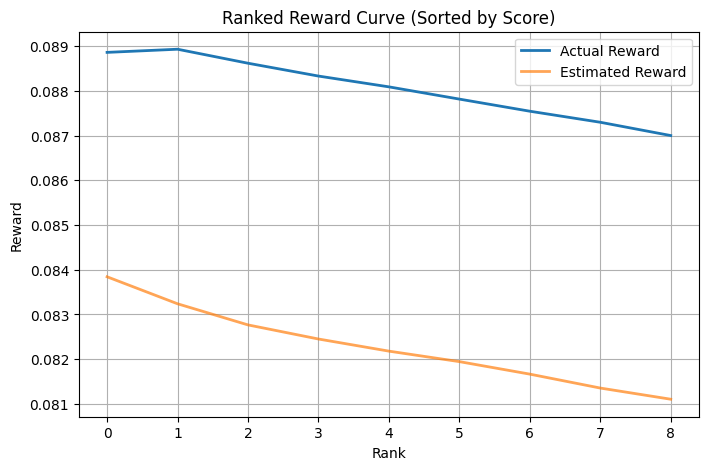

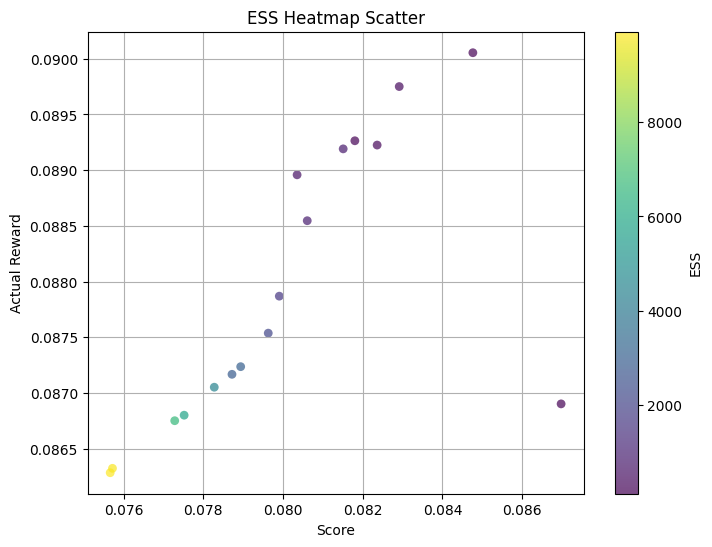

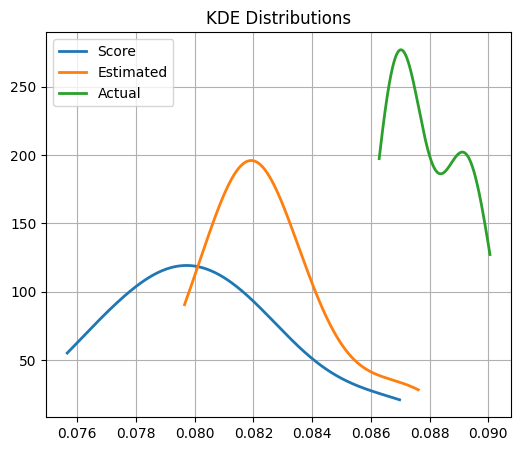

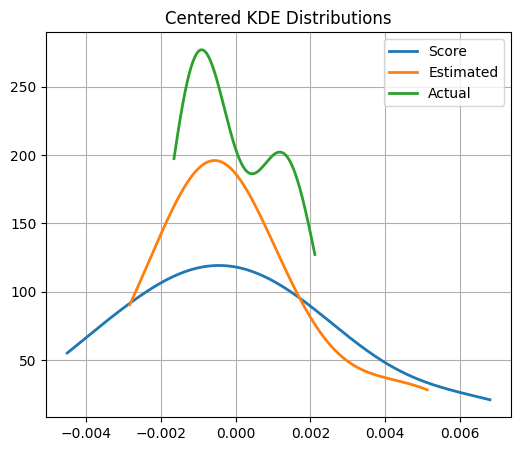

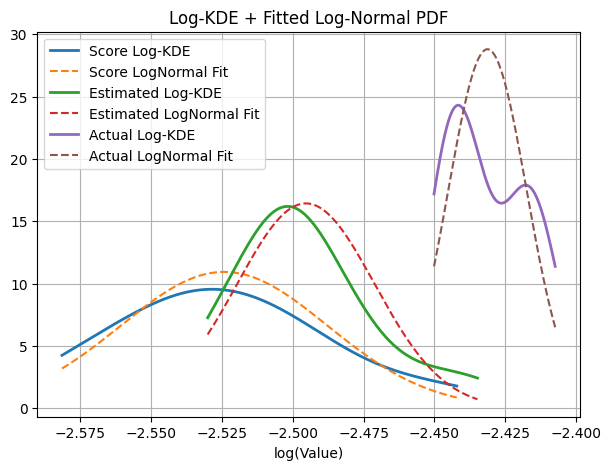

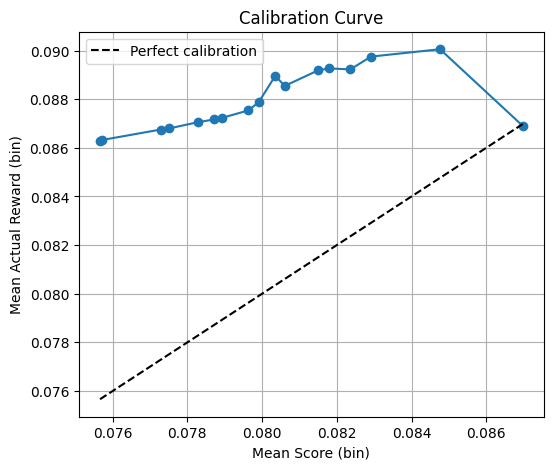

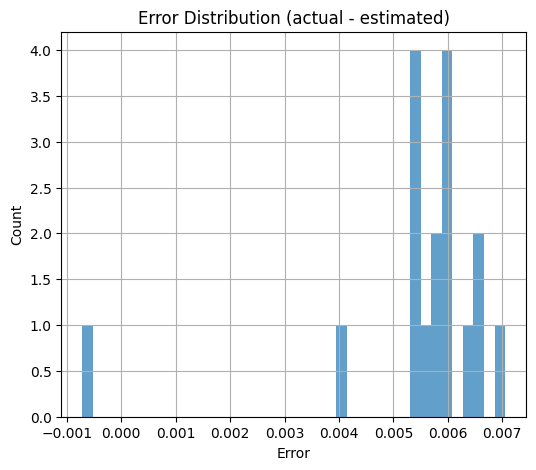

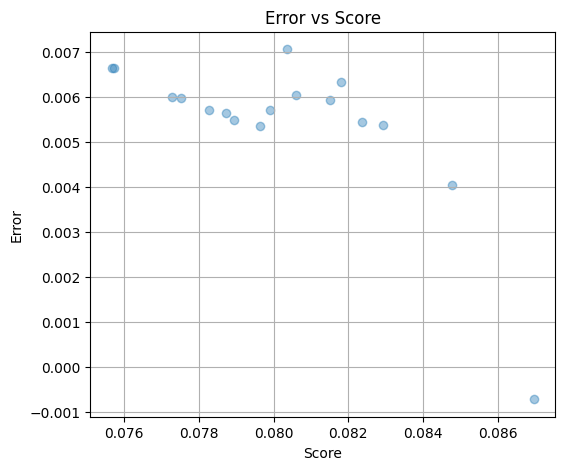

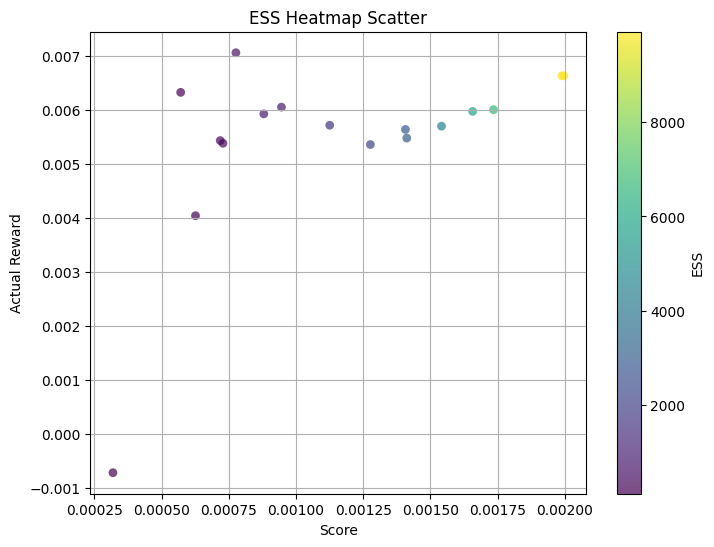

Correlation Metrics: {'pearson_score_actual': np.float64(0.6503010279376953), 'spearman_score_actual': np.float64(0.8039215686274511), 'spearman_est_actual': np.float64(0.7843137254901962)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9963504781089866), 'ndcg_est_actual': np.float64(0.9962774297394943)}
Error Metrics: {'mean_error': np.float64(0.005444530543551414), 'mae': np.float64(0.0055285933111696795), 'rmse': np.float64(0.005694885795999433), 'std_error': np.float64(0.0016699734697928098), 'max_error': np.float64(0.007052694192105899), 'min_error': np.float64(-0.0007145335247552564)}


In [32]:
compute_statistics_and_plots(study_df8)

In [33]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=50000)

Random Item CTR: 0.0705882181025533
Optimal greedy CTR: 0.09999934164533562
Second Best greedy CTR: 0.09924496289352924
Optimal Stochastic CTR: 0.09995498601895662
second Best Stochastic CTR: 0.08629000824986369
Our Initial CTR: 0.08647501952799874


In [34]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df9.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{50000}.csv")
# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.07052230834960938 seconds
[Regression] Baseline regression model fit time: 0.05s
Num samples is 10000
{'gini': np.float64(0.47916184902819287), 'ess': np.float64(3968.129799261727), 'max_wi': np.float64(37.74860168988597), 'min_wi': np.float64(0.007965517676346862)}
Eval time: 0.6761102676391602 seconds


[I 2025-12-09 10:42:39,284] A new study created in memory with name: no-name-a69b8a68-1717-4e2a-917b-a708282b11a5


Evaluation total results time: 1.14 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.07133102416992188 seconds


  0%|          | 0/27 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.07973911]
Validation weights_info: {'gini': np.float64(0.9879269970043724), 'ess': np.float64(101.27922026026299), 'max_wi': np.float64(323.0493122930083), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: 0.0995589:   4%|▎         | 1/27 [00:04<01:48,  4.19s/it]

[I 2025-12-09 10:42:43,472] Trial 0 finished with value: 0.099558856360661 and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 1
actual reward: [0.08905328]
Validation weights_info: {'gini': np.float64(0.9917107507631622), 'ess': np.float64(18.87374776281568), 'max_wi': np.float64(1247.1447996040752), 'min_wi': np.float64(1.4362970287950555e-19)}


Best trial: 0. Best value: 0.0995589:   7%|▋         | 2/27 [00:07<01:38,  3.93s/it]

[I 2025-12-09 10:42:47,216] Trial 1 finished with value: -inf and parameters: {'lr': 0.062280148447613065, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8275813151697333}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 2
actual reward: [0.09148563]
Validation weights_info: {'gini': np.float64(0.9136412082249051), 'ess': np.float64(636.8420982617763), 'max_wi': np.float64(60.4662937528072), 'min_wi': np.float64(2.7693885863699227e-05)}


Best trial: 0. Best value: 0.0995589:  11%|█         | 3/27 [00:10<01:17,  3.25s/it]

[I 2025-12-09 10:42:49,651] Trial 2 finished with value: 0.09293708973856271 and parameters: {'lr': 0.004256956820260303, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9120629315477342}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 3
actual reward: [0.09143628]
Validation weights_info: {'gini': np.float64(0.9606936095008981), 'ess': np.float64(352.4977031887111), 'max_wi': np.float64(81.97891027974245), 'min_wi': np.float64(1.6052946522980105e-06)}


Best trial: 0. Best value: 0.0995589:  15%|█▍        | 4/27 [00:11<00:59,  2.58s/it]

[I 2025-12-09 10:42:51,208] Trial 3 finished with value: 0.09402385191655362 and parameters: {'lr': 0.0306431765553244, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9947533118715539}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 4
actual reward: [0.09242968]
Validation weights_info: {'gini': np.float64(0.9461097995802704), 'ess': np.float64(363.0657586017346), 'max_wi': np.float64(161.83311392722467), 'min_wi': np.float64(1.9603857037400127e-06)}


Best trial: 0. Best value: 0.0995589:  19%|█▊        | 5/27 [00:14<01:00,  2.73s/it]

[I 2025-12-09 10:42:54,217] Trial 4 finished with value: 0.09247594713322026 and parameters: {'lr': 0.004553360484571099, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9152362749107561}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 5
actual reward: [0.08649458]
Validation weights_info: {'gini': np.float64(0.015315466247466181), 'ess': np.float64(9992.0098847512), 'max_wi': np.float64(1.084202603103428), 'min_wi': np.float64(0.9462584489102729)}


Best trial: 0. Best value: 0.0995589:  22%|██▏       | 6/27 [00:16<00:48,  2.30s/it]

[I 2025-12-09 10:42:55,676] Trial 5 finished with value: 0.07763614069686615 and parameters: {'lr': 0.00028250230067388224, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9649622940046501}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 6
actual reward: [0.07776259]
Validation weights_info: {'gini': np.float64(0.9968408552973369), 'ess': np.float64(7.439880247013507), 'max_wi': np.float64(3582.198707304795), 'min_wi': np.float64(8.626424042132488e-22)}


Best trial: 0. Best value: 0.0995589:  26%|██▌       | 7/27 [00:18<00:45,  2.26s/it]

[I 2025-12-09 10:42:57,839] Trial 6 finished with value: -inf and parameters: {'lr': 0.08051184768272016, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9835130192054518}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 7
actual reward: [0.09245991]
Validation weights_info: {'gini': np.float64(0.9676994280154798), 'ess': np.float64(201.3324186125219), 'max_wi': np.float64(310.55881492522246), 'min_wi': np.float64(2.850973793861823e-07)}


Best trial: 0. Best value: 0.0995589:  30%|██▉       | 8/27 [00:20<00:42,  2.26s/it]

[I 2025-12-09 10:43:00,111] Trial 7 finished with value: 0.09206997028684145 and parameters: {'lr': 0.013361982589369091, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.925534843575404}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 8
actual reward: [0.08655861]
Validation weights_info: {'gini': np.float64(0.05951642412148115), 'ess': np.float64(9875.951446398318), 'max_wi': np.float64(1.3556111919805334), 'min_wi': np.float64(0.8091599876158334)}


Best trial: 0. Best value: 0.0995589:  33%|███▎      | 9/27 [00:22<00:38,  2.16s/it]

[I 2025-12-09 10:43:02,057] Trial 8 finished with value: 0.07793109049232107 and parameters: {'lr': 0.0003121004025886345, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8183582209170944}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 9
actual reward: [0.08684905]
Validation weights_info: {'gini': np.float64(0.22694163526661137), 'ess': np.float64(8299.334091303592), 'max_wi': np.float64(2.9490691653845618), 'min_wi': np.float64(0.41207635263729026)}


Best trial: 0. Best value: 0.0995589:  37%|███▋      | 10/27 [00:25<00:37,  2.19s/it]

[I 2025-12-09 10:43:04,313] Trial 9 finished with value: 0.07973839703367733 and parameters: {'lr': 0.0007156438971123452, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8173706840737525}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 10
actual reward: [0.08783269]
Validation weights_info: {'gini': np.float64(0.5704314027737951), 'ess': np.float64(3468.1843482084487), 'max_wi': np.float64(10.546372726436786), 'min_wi': np.float64(0.05328960181260363)}


Best trial: 0. Best value: 0.0995589:  41%|████      | 11/27 [00:27<00:38,  2.40s/it]

[I 2025-12-09 10:43:07,192] Trial 10 finished with value: 0.08561025493340675 and parameters: {'lr': 0.0011938020581038552, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8631675541468292}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 11
actual reward: [0.08832015]
Validation weights_info: {'gini': np.float64(0.9782001324053351), 'ess': np.float64(36.252803621124855), 'max_wi': np.float64(1165.3824818229589), 'min_wi': np.float64(3.952352794489119e-08)}


Best trial: 0. Best value: 0.0995589:  44%|████▍     | 12/27 [00:29<00:33,  2.26s/it]

[I 2025-12-09 10:43:09,139] Trial 11 finished with value: -inf and parameters: {'lr': 0.021627291507066305, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8670555837188452}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 12
actual reward: [0.09100118]
Validation weights_info: {'gini': np.float64(0.996718936808468), 'ess': np.float64(1.6446736353991998), 'max_wi': np.float64(24975.802525520052), 'min_wi': np.float64(8.88477329995277e-14)}


Best trial: 0. Best value: 0.0995589:  48%|████▊     | 13/27 [00:32<00:35,  2.51s/it]

[I 2025-12-09 10:43:12,201] Trial 12 finished with value: -inf and parameters: {'lr': 0.023465065959549263, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8581021571023638}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 13
actual reward: [0.08255796]
Validation weights_info: {'gini': np.float64(0.9982578810313297), 'ess': np.float64(9.068338393699568), 'max_wi': np.float64(1089.2388712608083), 'min_wi': np.float64(4.504365540131985e-16)}


Best trial: 0. Best value: 0.0995589:  52%|█████▏    | 14/27 [00:35<00:32,  2.48s/it]

[I 2025-12-09 10:43:14,609] Trial 13 finished with value: -inf and parameters: {'lr': 0.066687284490015, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9522108679643437}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 14
actual reward: [0.0894344]
Validation weights_info: {'gini': np.float64(0.9762007650548877), 'ess': np.float64(78.5813196079548), 'max_wi': np.float64(438.2299379874727), 'min_wi': np.float64(1.485480912290933e-07)}


Best trial: 0. Best value: 0.0995589:  56%|█████▌    | 15/27 [00:37<00:29,  2.45s/it]

[I 2025-12-09 10:43:16,999] Trial 14 finished with value: -inf and parameters: {'lr': 0.009955538078427455, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9941721360796244}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 15
actual reward: [0.09316425]
Validation weights_info: {'gini': np.float64(0.970050346885672), 'ess': np.float64(256.04996025875505), 'max_wi': np.float64(209.45557849129827), 'min_wi': np.float64(2.3252523356267643e-08)}


Best trial: 0. Best value: 0.0995589:  59%|█████▉    | 16/27 [00:39<00:24,  2.21s/it]

[I 2025-12-09 10:43:18,660] Trial 15 finished with value: 0.09480996380319033 and parameters: {'lr': 0.03381011412454605, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.879376819759884}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 16
actual reward: [0.08287542]
Validation weights_info: {'gini': np.float64(0.9901880603655404), 'ess': np.float64(66.26323857766958), 'max_wi': np.float64(709.6556526671658), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: 0.0995589:  63%|██████▎   | 17/27 [00:43<00:28,  2.89s/it]

[I 2025-12-09 10:43:23,137] Trial 16 finished with value: -inf and parameters: {'lr': 0.0965239666271358, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8888418473689097}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 17
actual reward: [0.08903825]
Validation weights_info: {'gini': np.float64(0.9701866904718521), 'ess': np.float64(78.45200706692152), 'max_wi': np.float64(608.0050544424007), 'min_wi': np.float64(8.010838406292069e-07)}


Best trial: 0. Best value: 0.0995589:  67%|██████▋   | 18/27 [00:46<00:24,  2.68s/it]

[I 2025-12-09 10:43:25,325] Trial 17 finished with value: -inf and parameters: {'lr': 0.00809631757179902, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8479906085887343}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 18
actual reward: [0.08899468]
Validation weights_info: {'gini': np.float64(0.7529922221951885), 'ess': np.float64(1868.1411676746093), 'max_wi': np.float64(23.468063995403394), 'min_wi': np.float64(0.00614267163315628)}


Best trial: 0. Best value: 0.0995589:  70%|███████   | 19/27 [00:49<00:23,  2.88s/it]

[I 2025-12-09 10:43:28,667] Trial 18 finished with value: 0.089350835609364 and parameters: {'lr': 0.0015861127919574317, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8857658890391724}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 19
actual reward: [0.08371769]
Validation weights_info: {'gini': np.float64(0.9932290630092301), 'ess': np.float64(10.777680059455635), 'max_wi': np.float64(2655.5309020249183), 'min_wi': np.float64(1.0238736875178152e-09)}


Best trial: 0. Best value: 0.0995589:  74%|███████▍  | 20/27 [00:51<00:18,  2.63s/it]

[I 2025-12-09 10:43:30,709] Trial 19 finished with value: -inf and parameters: {'lr': 0.03674672271496624, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.800638690666698}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 20
actual reward: [0.0897482]
Validation weights_info: {'gini': np.float64(0.9867633737808577), 'ess': np.float64(42.126503593978825), 'max_wi': np.float64(895.8196520697632), 'min_wi': np.float64(1.4582934397979148e-18)}


Best trial: 0. Best value: 0.0995589:  78%|███████▊  | 21/27 [00:54<00:16,  2.68s/it]

[I 2025-12-09 10:43:33,498] Trial 20 finished with value: -inf and parameters: {'lr': 0.04220815294199572, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8361225114259104}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 21
actual reward: [0.09134182]
Validation weights_info: {'gini': np.float64(0.9510216812275849), 'ess': np.float64(404.75629192964635), 'max_wi': np.float64(76.94455294562238), 'min_wi': np.float64(9.227092151201946e-06)}


Best trial: 0. Best value: 0.0995589:  81%|████████▏ | 22/27 [00:55<00:11,  2.31s/it]

[I 2025-12-09 10:43:34,952] Trial 21 finished with value: 0.09469107799994218 and parameters: {'lr': 0.02480163471140524, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9353650229594024}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 22
actual reward: [0.09035881]
Validation weights_info: {'gini': np.float64(0.9104979909625814), 'ess': np.float64(613.8382326260827), 'max_wi': np.float64(53.70921724602643), 'min_wi': np.float64(0.000263415754289116)}


Best trial: 0. Best value: 0.0995589:  85%|████████▌ | 23/27 [00:57<00:08,  2.02s/it]

[I 2025-12-09 10:43:36,301] Trial 22 finished with value: 0.09346655193155602 and parameters: {'lr': 0.01588819344310865, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9336618900750027}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 23
actual reward: [0.08650495]
Validation weights_info: {'gini': np.float64(0.022176921106879303), 'ess': np.float64(9983.02301996485), 'max_wi': np.float64(1.1271664937251857), 'min_wi': np.float64(0.9227678531747554)}


Best trial: 0. Best value: 0.0995589:  89%|████████▉ | 24/27 [00:58<00:05,  1.98s/it]

[I 2025-12-09 10:43:38,172] Trial 23 finished with value: 0.0776732004367467 and parameters: {'lr': 0.00012399781414641192, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8786195769616352}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 24
actual reward: [0.08934789]
Validation weights_info: {'gini': np.float64(0.8112412189016273), 'ess': np.float64(1231.7424385857455), 'max_wi': np.float64(30.0643082092134), 'min_wi': np.float64(0.0043728271669974525)}


Best trial: 0. Best value: 0.0995589:  93%|█████████▎| 25/27 [01:00<00:03,  1.90s/it]

[I 2025-12-09 10:43:39,909] Trial 24 finished with value: 0.0909760863773157 and parameters: {'lr': 0.00745114736131104, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.899282733125357}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 25
actual reward: [0.09124783]
Validation weights_info: {'gini': np.float64(0.9501790387866408), 'ess': np.float64(429.6252562522486), 'max_wi': np.float64(63.971701792060976), 'min_wi': np.float64(1.1652345692187448e-06)}


Best trial: 0. Best value: 0.0995589:  96%|█████████▋| 26/27 [01:01<00:01,  1.73s/it]

[I 2025-12-09 10:43:41,243] Trial 25 finished with value: 0.09367438046663522 and parameters: {'lr': 0.04522696088032329, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.942594161267204}. Best is trial 0 with value: 0.099558856360661.

[Regression] Optuna Trial 26
actual reward: [0.08603814]
Validation weights_info: {'gini': np.float64(0.9947021396074245), 'ess': np.float64(11.767520445823394), 'max_wi': np.float64(2255.8830023332503), 'min_wi': np.float64(2.1164300790626763e-12)}


Best trial: 0. Best value: 0.0995589: 100%|██████████| 27/27 [01:04<00:00,  2.39s/it]


[I 2025-12-09 10:43:43,933] Trial 26 finished with value: -inf and parameters: {'lr': 0.020060081648480207, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9076346864803987}. Best is trial 0 with value: 0.099558856360661.
Num samples is 10000
{'gini': np.float64(0.9968155170980985), 'ess': np.float64(21.58317608793496), 'max_wi': np.float64(795.7634852649189), 'min_wi': np.float64(3.887313966231657e-25)}
Eval time: 0.47468090057373047 seconds
Evaluation total results time: 0.84 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08647502,0.08740000,0.08739647,0.08739647,0.08737089,0.08737089,0.80232812,0.00000000,0.84032376,0.00000000
15000,0.08440944,0.05362063,0.09151492,0.09151492,0.06843159,0.05491096,1.09006707,0.70383255,1.16237548,0.69026308


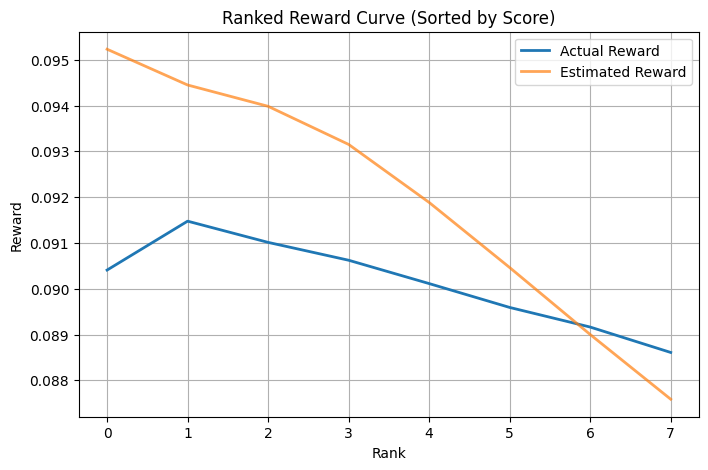

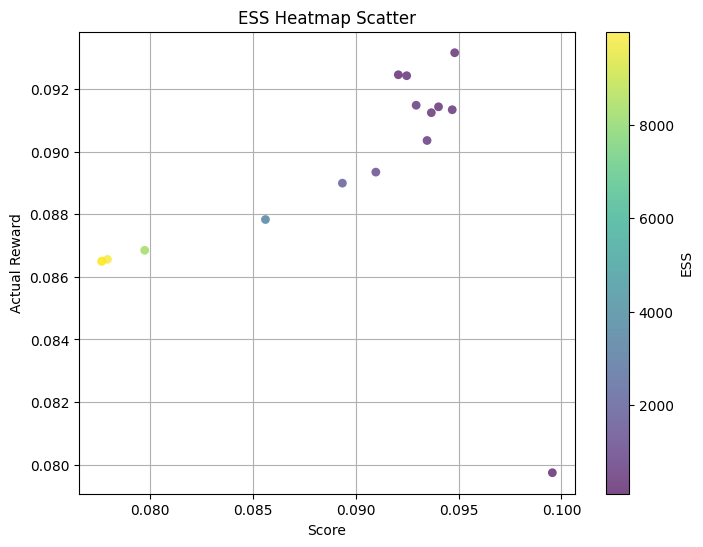

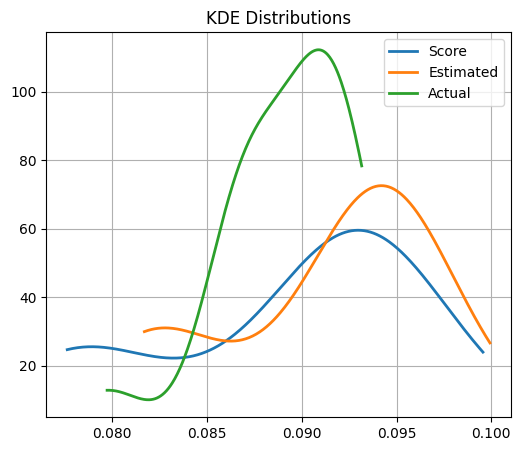

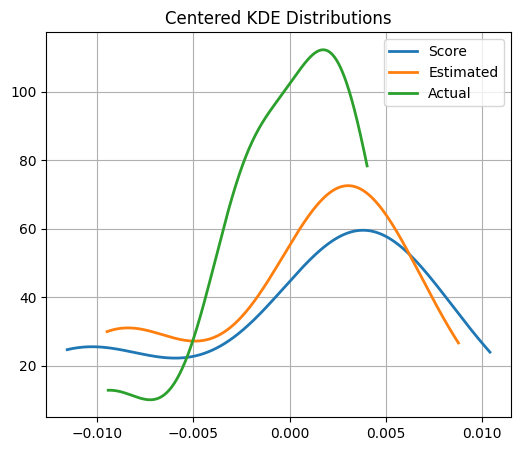

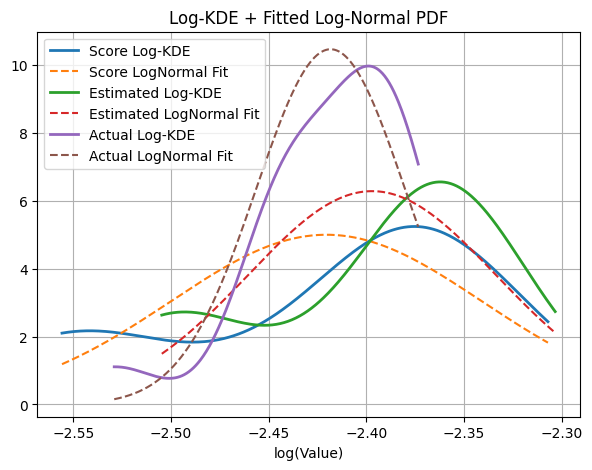

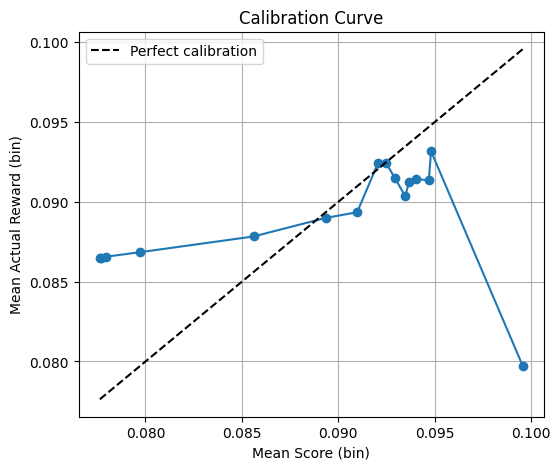

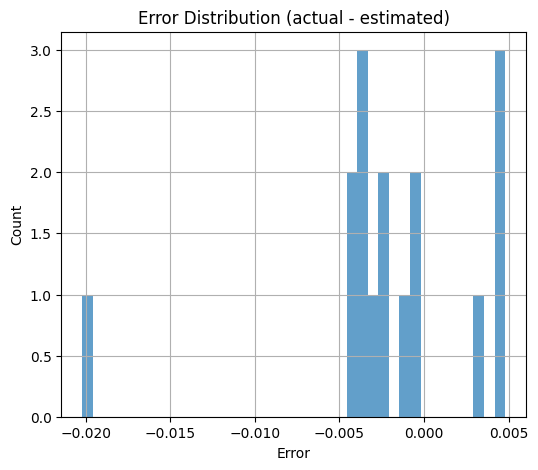

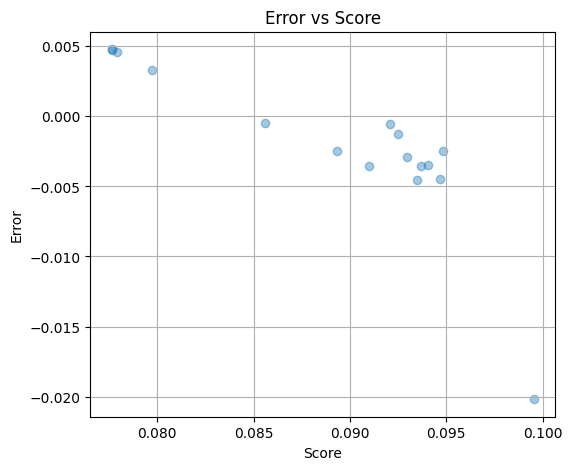

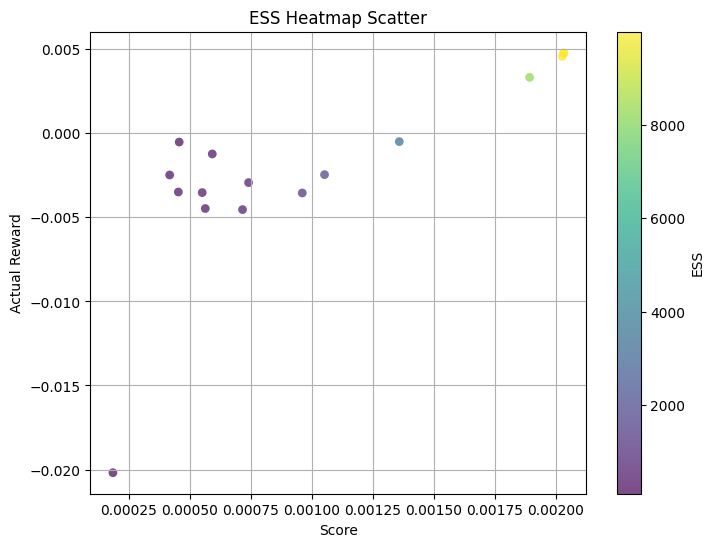

Correlation Metrics: {'pearson_score_actual': np.float64(0.29743265519986806), 'spearman_score_actual': np.float64(0.5088235294117647), 'spearman_est_actual': np.float64(0.4911764705882353)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9815706472447289), 'ndcg_est_actual': np.float64(0.9810718549361233)}
Error Metrics: {'mean_error': np.float64(-0.002028336204889303), 'mae': np.float64(0.0042096989617745875), 'rmse': np.float64(0.006051758955741126), 'std_error': np.float64(0.00570172243259247), 'max_error': np.float64(0.004790157350312491), 'min_error': np.float64(-0.02018937635890683)}


In [35]:
compute_statistics_and_plots(study_df9)

In [36]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
# all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [37]:
all_dfs.head(5)

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat,user_attrs_ess,user_attrs_scores_dict,user_attrs_all_values
0,0.08424054,0.09088038,0.00056342,0.08536738,296.98240138,"{'dr_naive_mean': 0.08536737754727662, 'dr_nai...","[0.08536737754727662, 0.08539365474634907, 0.0..."
1,0.07645630,0.08630128,0.00174318,0.07994265,"7,138.61130647","{'dr_naive_mean': 0.07994265160577554, 'dr_nai...","[0.07994265160577554, 0.08008141673538335, 0.0..."
2,0.08172643,0.09132558,0.00070798,0.08314239,688.84242340,"{'dr_naive_mean': 0.08314238533621202, 'dr_nai...","[0.08314238533621202, 0.08316411905176417, 0.0..."
3,0.07849647,0.08680515,0.00116741,0.08083128,"2,606.13168269","{'dr_naive_mean': 0.08083128053407464, 'dr_nai...","[0.08083128053407464, 0.08086161338228845, 0.0..."
4,0.07598168,0.08614904,0.00199185,0.07996537,"9,782.98154134","{'dr_naive_mean': 0.07996537193857249, 'dr_nai...","[0.07996537193857249, 0.07994466088063976, 0.0..."


In [38]:
from plots_and_stats import compute_statistics_and_plots
import pandas as pd

In [39]:
all_dfs.to_csv(f"trial_dfs/regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv", index=False)

In [40]:
all_dfs = pd.read_csv(f"regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'regression_model_opl_study_results_all_seeds_27.csv'

In [ ]:
compute_statistics_and_plots(all_dfs)